In [12]:
RUN_BY_MYSELF = False  # switch to enable file storage, False:if you don't want to storage any files

# load pandas and read the csv file from the url
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import requests
import zipfile
from io import BytesIO
warnings.filterwarnings("ignore")
# read local data csv
# df = pd.read_csv("./stack-overflow-developer-survey-2024/survey_results_public.csv", )


url = "https://survey.stackoverflow.co/datasets/stack-overflow-developer-survey-2024.zip"
resp = requests.get(url)
resp.raise_for_status()

with zipfile.ZipFile(BytesIO(resp.content)) as z:
    # show all file names
    names = z.namelist()
    print("Files in ZIP:", names)

    # Option: read all CSVs into dict
    dfs = {}
    for fname in names:
        if fname.lower().endswith(".csv"):
            with z.open(fname) as f:
                dfs[fname] = pd.read_csv(f)

    # Example: show head of each
    for fname, df in dfs.items():
        print("===", fname, "→", df.shape)
        print(df.head())

    # Option: combine them (if same columns)
    # combined = pd.concat(dfs.values(), ignore_index=True)
    # print("Combined shape:", combined.shape)
df = dfs['survey_results_public.csv']

# basic EDA function
def basic_info(column):
    print(df[column].head())
    print('-'*40)
    print(df[column].tail())
    print('-'*40)
    print(df[column].isnull().sum())
    print('-'*40)
    print(df[column].value_counts())
    print('-'*40)
    print('*'*40)

WaitForOneHotEncoder = [] # create a list to store the columns that need to be one-hot encoded later

# simple distribution plot function
def bin_distribution(column, bins=10,rotate=0):
    plt.figure(figsize=(12,6))
    sns.histplot(df[column], bins=bins, kde=False)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    # rotate x labels
    if rotate:
        plt.xticks(rotation=rotate)
    plt.show()

def base_on_group_fill_median(target_column, target_group_list):
    return df.groupby(target_group_list)['target_column'].median()

# don't overthink this function, it is just a fast way to explode a column with multiple values separated by a delimiter and one-hot encode the result, it is for machine learning data cleaning purpose, not for data analysis
def fast_explode(target_dataframe, target_column, fillna='', split=';', prefix='worked with', tmp_column_name='tmp_c'):
    # Step 1: Create a temporary column with split and prefix
    _exploded = (
        target_dataframe.assign(
            **{tmp_column_name: target_dataframe[target_column]
                .fillna(fillna)
                .str.split(split)
                .apply(lambda lst: [f"{prefix} {lang.strip()}" for lang in lst if lang])
            }
        )
        .explode(tmp_column_name)
    )

    # Step 2: One-hot encode
    _one_hot = pd.crosstab(index=_exploded.index, columns=_exploded[tmp_column_name]).astype(bool)

    # Step 3: Combine with original DataFrame
    print(target_column, _one_hot.shape[0], target_dataframe.shape[0])
    result = pd.concat([target_dataframe.drop(columns=[target_column]), _one_hot], axis=1)
    result[_one_hot.columns] = result[_one_hot.columns].fillna(False)

    return result


# let's take a look at the data
print(df.head())
print(df.describe())
print(df.info())

for c in df.columns:
    print(f"{c}")

Files in ZIP: ['2024 Developer Survey.pdf', 'survey_results_public.csv', 'survey_results_schema.csv']
=== survey_results_public.csv → (65437, 114)
   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   

# we can see null values throughout all columns, few columns have filled with  full values.

# now we will look into the data and see what we can do to clean it up and make it ready for analysis.

In [13]:
# start checking..
basic_info("ResponseId")

# so response_id can be used as index
df.set_index('ResponseId', inplace=True) # setting index

0    1
1    2
2    3
3    4
4    5
Name: ResponseId, dtype: int64
----------------------------------------
65432    65433
65433    65434
65434    65435
65435    65436
65436    65437
Name: ResponseId, dtype: int64
----------------------------------------
0
----------------------------------------
ResponseId
1        1
2        1
3        1
4        1
5        1
        ..
65433    1
65434    1
65435    1
65436    1
65437    1
Name: count, Length: 65437, dtype: int64
----------------------------------------
****************************************


In [14]:
# start checking..
basic_info("MainBranch")

# main_branch seems like a categorical data, wait for one-hot encoding later
WaitForOneHotEncoder.append("MainBranch")

ResponseId
1    I am a developer by profession
2    I am a developer by profession
3    I am a developer by profession
4             I am learning to code
5    I am a developer by profession
Name: MainBranch, dtype: object
----------------------------------------
ResponseId
65433    I am a developer by profession
65434    I am a developer by profession
65435    I am a developer by profession
65436    I am a developer by profession
65437       I code primarily as a hobby
Name: MainBranch, dtype: object
----------------------------------------
0
----------------------------------------
MainBranch
I am a developer by profession                                                           50207
I am not primarily a developer, but I write code sometimes as part of my work/studies     6511
I am learning to code                                                                     3875
I code primarily as a hobby                                                               3334
I used to be a dev

In [15]:
basic_info("Age")
WaitForOneHotEncoder.append("Age")

ResponseId
1    Under 18 years old
2       35-44 years old
3       45-54 years old
4       18-24 years old
5       18-24 years old
Name: Age, dtype: object
----------------------------------------
ResponseId
65433    18-24 years old
65434    25-34 years old
65435    25-34 years old
65436    18-24 years old
65437    18-24 years old
Name: Age, dtype: object
----------------------------------------
0
----------------------------------------
Age
25-34 years old       23911
35-44 years old       14942
18-24 years old       14098
45-54 years old        6249
55-64 years old        2575
Under 18 years old     2568
65 years or older       772
Prefer not to say       322
Name: count, dtype: int64
----------------------------------------
****************************************


age is categorical data, we can keep it as it is. But I assume it represented register age/ working experience, not the actual age of the respondents

In [16]:
basic_info("RemoteWork")
WaitForOneHotEncoder.append("RemoteWork")
df['RemoteWork'] = df['RemoteWork'].fillna('not filled')# filling null values with 0


ResponseId
1    Remote
2    Remote
3    Remote
4       NaN
5       NaN
Name: RemoteWork, dtype: object
----------------------------------------
ResponseId
65433                                  Remote
65434                                  Remote
65435                               In-person
65436    Hybrid (some remote, some in-person)
65437                                     NaN
Name: RemoteWork, dtype: object
----------------------------------------
10631
----------------------------------------
RemoteWork
Hybrid (some remote, some in-person)    23015
Remote                                  20831
In-person                               10960
Name: count, dtype: int64
----------------------------------------
****************************************


remote_work is categorical data, we can keep it as it is. And fill the null values with 0, meaning no remote work/experience

In [17]:
basic_info("EdLevel")
WaitForOneHotEncoder.append("EdLevel")
df['EdLevel'] = df['EdLevel'].fillna('not filled')

ResponseId
1                            Primary/elementary school
2         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
3      Master’s degree (M.A., M.S., M.Eng., MBA, etc.)
4    Some college/university study without earning ...
5    Secondary school (e.g. American high school, G...
Name: EdLevel, dtype: object
----------------------------------------
ResponseId
65433         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65434                                                  NaN
65435         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65436    Secondary school (e.g. American high school, G...
65437                                                  NaN
Name: EdLevel, dtype: object
----------------------------------------
4653
----------------------------------------
EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          24942
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       15557
Some college/university study 

In [18]:
basic_info("Check")
# only 1 value drop this column
df.drop(columns=['Check'], inplace=True)

ResponseId
1    Apples
2    Apples
3    Apples
4    Apples
5    Apples
Name: Check, dtype: object
----------------------------------------
ResponseId
65433    Apples
65434    Apples
65435    Apples
65436    Apples
65437    Apples
Name: Check, dtype: object
----------------------------------------
0
----------------------------------------
Check
Apples    65437
Name: count, dtype: int64
----------------------------------------
****************************************


In [19]:
# CodingActivities
basic_info("CodingActivities")
df = fast_explode(df,target_column='CodingActivities', fillna='', split=';', prefix='coding_activities ')


ResponseId
1                                                Hobby
2    Hobby;Contribute to open-source projects;Other...
3    Hobby;Contribute to open-source projects;Other...
4                                                  NaN
5                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
ResponseId
65433                        Hobby;School or academic work
65434             Hobby;Contribute to open-source projects
65435                                                Hobby
65436    Hobby;Contribute to open-source projects;Profe...
65437                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
10971
----------------------------------------
CodingActivities
Hobby                                                                                                                                                                              9993
I 

1    Employed, full-time
2    Employed, full-time
3    Employed, full-time
4     Student, full-time
5     Student, full-time
Name: Employment, dtype: object
----------------------------------------
65433    Employed, full-time
65434    Employed, full-time
65435    Employed, full-time
65436    Employed, full-time
65437     Student, full-time
Name: Employment, dtype: object
----------------------------------------
0
----------------------------------------
Employment
Employed, full-time                                                                                                                                   39041
Independent contractor, freelancer, or self-employed                                                                                                   4846
Student, full-time                                                                                                                                     4709
Employed, full-time;Independent contractor, freelancer, or sel

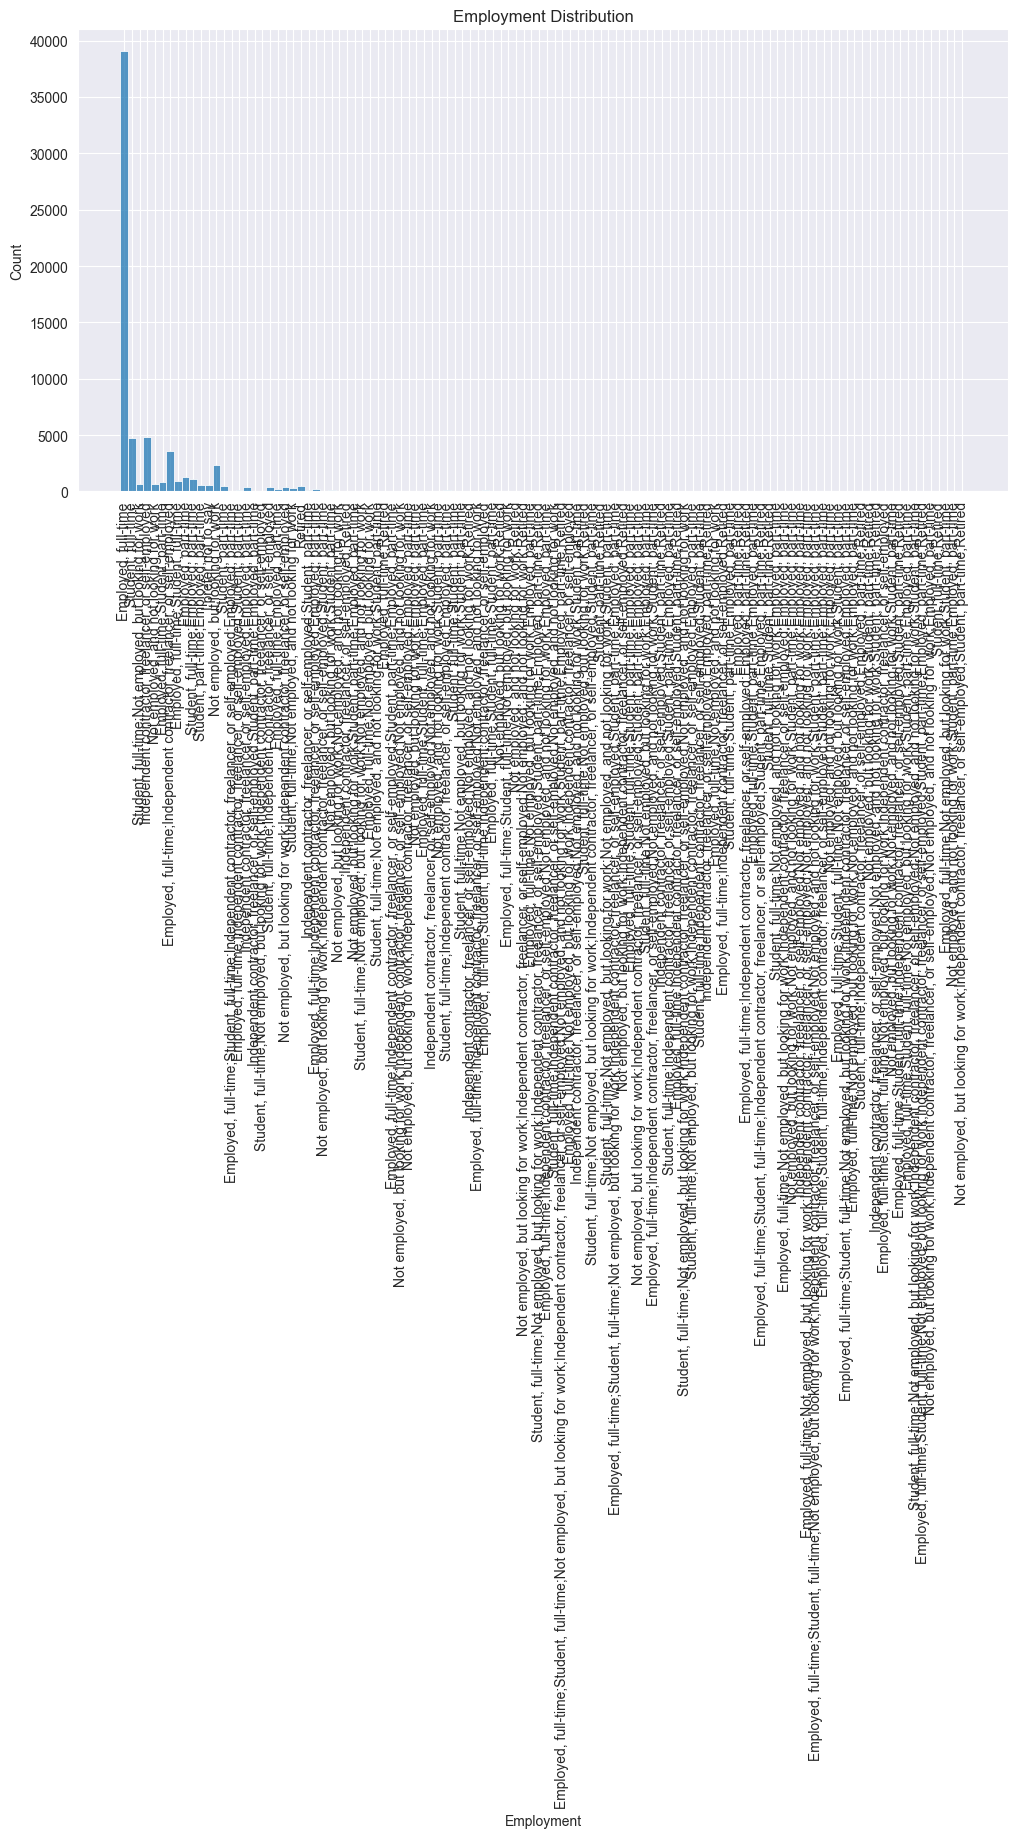

In [20]:
basic_info("Employment")
WaitForOneHotEncoder.append("Employment")
df['Employment'] = df['Employment'].fillna('not filled')
# plot distribution of Employment column
bin_distribution("Employment", bins=len(df['Employment'].unique())+1,rotate=90)



In [21]:
# categorical data, a lot null values
basic_info('LearnCode')
basic_info('LearnCodeOnline')
basic_info('TechDoc')
for col in ['LearnCode', 'LearnCodeOnline', 'TechDoc']:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')


1                               Books / Physical media
2    Books / Physical media;Colleague;On the job tr...
3    Books / Physical media;Colleague;On the job tr...
4    Other online resources (e.g., videos, blogs, f...
5    Other online resources (e.g., videos, blogs, f...
Name: LearnCode, dtype: object
----------------------------------------
65433    On the job training;School (i.e., University, ...
65434                                                  NaN
65435    Other online resources (e.g., videos, blogs, f...
65436    On the job training;Other online resources (e....
65437                                                  NaN
Name: LearnCode, dtype: object
----------------------------------------
4949
----------------------------------------
LearnCode
Other online resources (e.g., videos, blogs, forum, online community)                                                                                                 3674
Books / Physical media;Other online resources (e.g., videos

In [49]:
df['YearsCode'] = df['YearsCode'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')  # 字符→数值；不可解析→NaN

td = df.groupby(['EdLevel','Country'])['YearsCode'].median()
print(td)

EdLevel                              Country                             
Associate degree (A.A., A.S., etc.)  Afghanistan                              7.5
                                     Albania                                  5.0
                                     Algeria                                  1.0
                                     Andorra                                  3.0
                                     Angola                                   4.0
                                                                             ... 
Something else                       United States of America                 5.0
                                     Uruguay                                 34.0
                                     Uzbekistan                              35.0
                                     Venezuela, Bolivarian Republic of...    15.5
                                     Viet Nam                                 5.5
Name: YearsCode, Length:

In [37]:
basic_info('YearsCode')
# 2 unique string values 'Less than 1 year' and 'More than 50 years'
# convert them to 0 and 51
df['YearsCode'] = df['YearsCode'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCode")
# need to handle the null values
df['YearsCode'] = df['YearsCode'].fillna(df['YearsCode'].mode())
df['YearsCode'] = df['YearsCode'].astype(int)
bin_distribution('YearsCode', bins=52)

1    NaN
2     20
3     37
4      4
5      9
Name: YearsCode, dtype: object
----------------------------------------
65433      5
65434    NaN
65435      9
65436      5
65437    NaN
Name: YearsCode, dtype: object
----------------------------------------
5568
----------------------------------------
YearsCode
10    4561
5     3723
6     3496
8     3449
7     3333
4     3290
15    2813
20    2636
12    2559
3     2518
9     2251
14    1822
25    1671
2     1642
11    1636
13    1477
30    1461
16    1401
18    1228
17    1038
40     993
24     870
22     842
35     735
1      712
23     634
26     630
0      569
19     561
21     522
28     512
27     504
32     328
34     293
42     289
38     285
29     274
45     257
51     254
36     223
33     219
37     216
44     195
43     173
41     147
31     146
39     145
46      98
50      77
48      64
47      63
49      34
Name: count, dtype: int64
----------------------------------------
****************************************
1    NaN
2

ValueError: cannot convert float NaN to integer

1    NaN
2     17
3     27
4    NaN
5    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
65433      3
65434    NaN
65435      5
65436      2
65437    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
13827
----------------------------------------
YearsCodePro
2                     4168
3                     4093
5                     3526
10                    3251
4                     3215
Less than 1 year      2856
6                     2843
1                     2639
8                     2549
7                     2517
12                    1777
15                    1635
20                    1549
9                     1493
11                    1312
13                    1127
14                    1082
25                     998
16                     946
18                     867
17                     814
30                     689
24                     632
19                     516
22                     492
23   

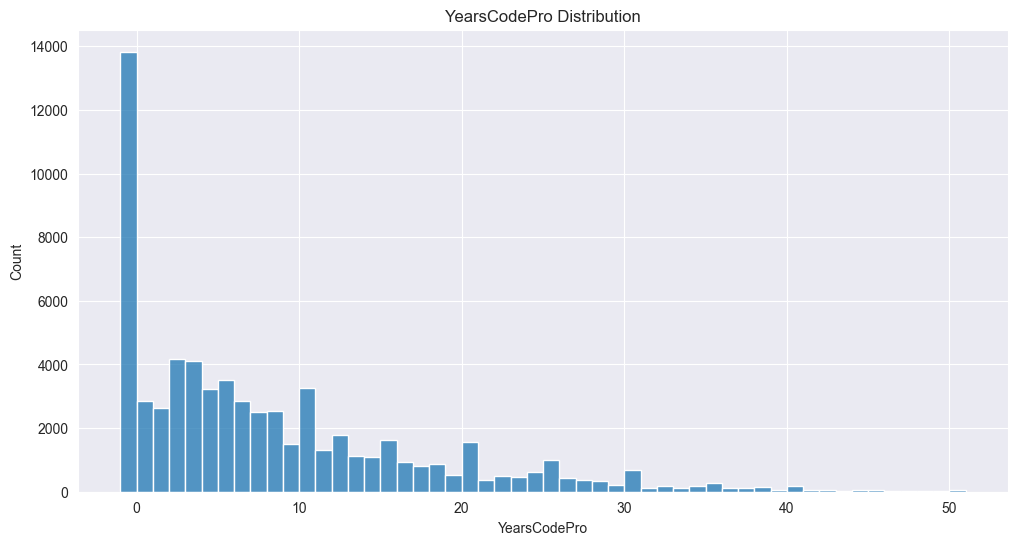

In [12]:
basic_info('YearsCodePro')
df['YearsCodePro'] = df['YearsCodePro'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCodePro")
# need to handle the null values
df['YearsCodePro'] = df['YearsCodePro'].fillna(df['YearsCodePro'].mode())

df['YearsCodePro'] = df['YearsCodePro'].astype(int)
bin_distribution('YearsCodePro', bins=52)

1                      NaN
2    Developer, full-stack
3     Developer Experience
4    Developer, full-stack
5    Developer, full-stack
Name: DevType, dtype: object
----------------------------------------
65433             Blockchain
65434                    NaN
65435      Developer, mobile
65436    Developer, back-end
65437                    NaN
Name: DevType, dtype: object
----------------------------------------
5992
----------------------------------------
DevType
Developer, full-stack                            18260
Developer, back-end                               9928
Student                                           5102
Developer, front-end                              3349
Developer, desktop or enterprise applications     2493
Other (please specify):                           2458
Developer, mobile                                 2021
Developer, embedded applications or devices       1623
Engineering manager                               1275
Academic researcher            

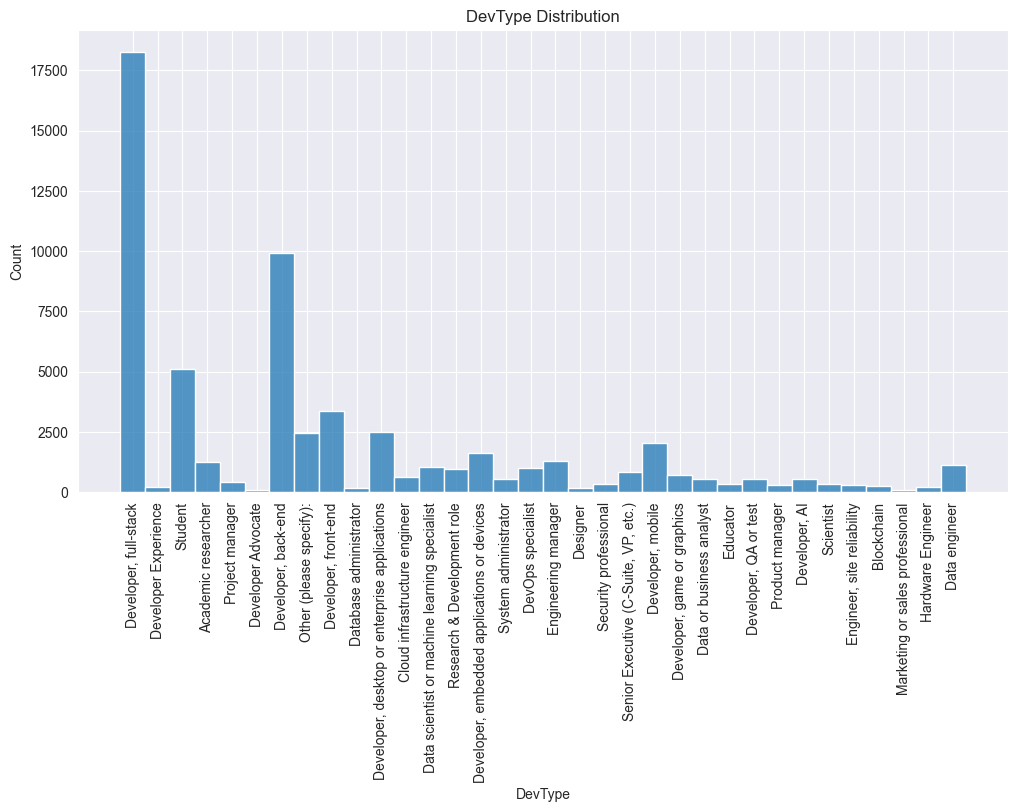

In [13]:
basic_info("DevType")
bin_distribution('DevType', bins=df['DevType'].nunique()+1,rotate=90)
WaitForOneHotEncoder.append("DevType")
df['DevType'] = df['DevType'].fillna('not filled')




1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: OrgSize, dtype: object
----------------------------------------
65433            2 to 9 employees
65434                         NaN
65435    1,000 to 4,999 employees
65436          20 to 99 employees
65437                         NaN
Name: OrgSize, dtype: object
----------------------------------------
17957
----------------------------------------
OrgSize
20 to 99 employees                                    9754
100 to 499 employees                                  8694
10,000 or more employees                              5558
1,000 to 4,999 employees                              5353
2 to 9 employees                                      4833
10 to 19 employees                                    4084
500 to 999 employees                                  3183
Just me - I am a freelancer, sole proprietor, etc.    3086
5,000 to 9,999 employees                              1867
I don’t know                                          1068


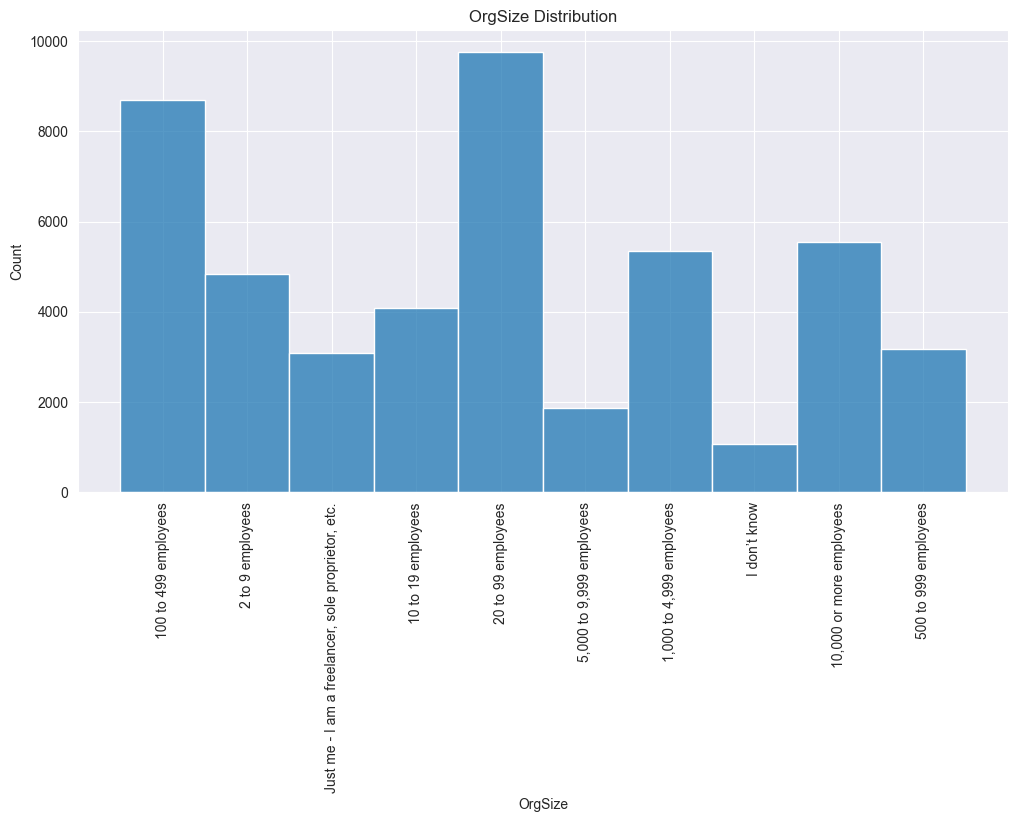

In [14]:
basic_info("OrgSize")
bin_distribution('OrgSize', bins=df['OrgSize'].nunique()+1,rotate=90)
# categorical data, a lot null values, fill null with -1 meaning no response/don't have an organization?
WaitForOneHotEncoder.append("OrgSize")
df['OrgSize'] = df['OrgSize'].fillna('not filled')




In [15]:
basic_info("PurchaseInfluence")
WaitForOneHotEncoder.append("PurchaseInfluence")
df['PurchaseInfluence'] = df['PurchaseInfluence'].fillna('not filled')


1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
65433            I have some influence
65434                              NaN
65435    I have little or no influence
65436            I have some influence
65437                              NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
18031
----------------------------------------
PurchaseInfluence
I have some influence               19197
I have little or no influence       17942
I have a great deal of influence    10267
Name: count, dtype: int64
----------------------------------------
****************************************


In [16]:
basic_info("BuyNewTool")# another need to expand categorial data
df = fast_explode(df,target_column='BuyNewTool', fillna='', split=';', prefix='buy_new_tool ')

basic_info('BuildvsBuy')
# don't plot this for the name is so long

WaitForOneHotEncoder.append("BuildvsBuy")
# filling null values with -1, meaning?
df['BuildvsBuy'] = df['BuildvsBuy'].fillna('not filled')



1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: BuyNewTool, dtype: object
----------------------------------------
65433    Ask developers I know/work with;Ask a generati...
65434                                                  NaN
65435    Ask developers I know/work with;Ask a generati...
65436    Start a free trial;Ask developers I know/work ...
65437                                                  NaN
Name: BuyNewTool, dtype: object
----------------------------------------
20256
----------------------------------------
BuyNewTool
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow                                                                            6619
Start a free trial;Ask developers I know/work with                                                                                                                            4927
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow

In [17]:
basic_info("LanguageHaveWorkedWith")
drop_columns = []
explode_columns = []
for col in df.columns:
    if 'HaveWorkedWith' in col:
        explode_columns.append(col)

    elif  'Admired' in col or 'WantTo' in col or 'SO' in col or 'AI' in col:
        drop_columns.append(col)

print(drop_columns)
print(explode_columns)
# drop first
df.drop(columns=drop_columns, inplace=True)

# expand
for col in explode_columns:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')
print(df.isnull().sum())

# Splits each string in LanguageHaveWorkedWith into a list of languages，Creates a new column called Language in the DataFrame. Converts each list in Language into multiple rows.
# df = fast_explode(df,target_column='LanguageHaveWorkedWith', fillna='', split=';', prefix='worked_with ')


1                                                  NaN
2    Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...
3                                                   C#
4    C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...
5              C++;HTML/CSS;JavaScript;Lua;Python;Rust
Name: LanguageHaveWorkedWith, dtype: object
----------------------------------------
65433                                                 NaN
65434                                                 NaN
65435                                                 NaN
65436            C;C++;Go;Lua;Objective-C;Python;Rust;SQL
65437    C;HTML/CSS;Java;JavaScript;PHP;Python;TypeScript
Name: LanguageHaveWorkedWith, dtype: object
----------------------------------------
5692
----------------------------------------
LanguageHaveWorkedWith
HTML/CSS;JavaScript;TypeScript                            1002
Python                                                     832
HTML/CSS;JavaScript;PHP;SQL                                503
HTML/CS

In [18]:
basic_info('ICorPM') #Individual Contributor or People Manager
# categorical data, a lot null values, fill null with -1
WaitForOneHotEncoder.append("ICorPM")
df['ICorPM'] = df['ICorPM'].fillna('not filled')



1                       NaN
2    Individual contributor
3                       NaN
4                       NaN
5                       NaN
Name: ICorPM, dtype: object
----------------------------------------
65433                       NaN
65434                       NaN
65435                       NaN
65436    Individual contributor
65437                       NaN
Name: ICorPM, dtype: object
----------------------------------------
35636
----------------------------------------
ICorPM
Individual contributor    25888
People manager             3913
Name: count, dtype: int64
----------------------------------------
****************************************


In [19]:

basic_info('WorkExp')
# numerical categorical data, a lot null values, fill null with -1
df['WorkExp'] = df['WorkExp'].fillna(df['WorkExp'].mode())

basic_info('Knowledge_1')
# from Knowledge_1 ~9 check the survey question, it is the long question about different things
for i in range(1,10):
    basic_info(f'Knowledge_{i}')
    WaitForOneHotEncoder.append(f'Knowledge_{i}')
    df[f'Knowledge_{i}'] = df[f'Knowledge_{i}'].fillna('not filled')

# Frequency_1 ~ 3 also
for i in range(1,4):
    basic_info(f'Frequency_{i}')
    WaitForOneHotEncoder.append(f'Frequency_{i}')
    df[f'Frequency_{i}'] = df[f'Frequency_{i}'].fillna('not filled')

basic_info('TimeSearching')
WaitForOneHotEncoder.append("TimeSearching")
df['TimeSearching'] = df['TimeSearching'].fillna('not filled')

basic_info('TimeAnswering')
WaitForOneHotEncoder.append("TimeAnswering")
df['TimeAnswering'] = df['TimeAnswering'].fillna('not filled')

basic_info('Frustration')
# change it's name to Challenge_Frustration
df.rename(columns={'Frustration': 'Challenge_Frustration'}, inplace=True)
WaitForOneHotEncoder.append("Challenge_Frustration")
df['Challenge_Frustration'] = df['Challenge_Frustration'].fillna('not filled')


basic_info('ProfessionalTech')
# change name to Company_ProfessionalTech
df.rename(columns={'ProfessionalTech': 'Company_ProfessionalTech'}, inplace=True)
WaitForOneHotEncoder.append("Company_ProfessionalTech")
df['Company_ProfessionalTech'] = df['Company_ProfessionalTech'].fillna('not filled')

basic_info('ProfessionalCloud')
WaitForOneHotEncoder.append("ProfessionalCloud")
df['ProfessionalCloud'] = df['ProfessionalCloud'].fillna('not filled')


basic_info('ProfessionalQuestion')
# change name to FirstAnswer(er)_ProfessionalQuestion
df.rename(columns={'ProfessionalQuestion': 'FirstAnswerer_ProfessionalQuestion'}, inplace=True)
WaitForOneHotEncoder.append("FirstAnswerer_ProfessionalQuestion")
df['FirstAnswerer_ProfessionalQuestion'] = df['FirstAnswerer_ProfessionalQuestion'].fillna('not filled')


basic_info('Industry')
WaitForOneHotEncoder.append("Industry")
df['Industry'] = df['Industry'].fillna('not filled')



1     NaN
2    17.0
3     NaN
4     NaN
5     NaN
Name: WorkExp, dtype: float64
----------------------------------------
65433    NaN
65434    NaN
65435    NaN
65436    5.0
65437    NaN
Name: WorkExp, dtype: float64
----------------------------------------
35779
----------------------------------------
WorkExp
3.0     2144
5.0     2050
10.0    2029
2.0     1885
4.0     1767
6.0     1600
7.0     1581
8.0     1554
1.0     1461
15.0    1250
12.0    1249
20.0    1074
9.0      982
11.0     823
25.0     794
13.0     740
14.0     655
16.0     600
17.0     596
18.0     587
30.0     461
24.0     382
19.0     330
22.0     323
23.0     269
26.0     254
21.0     251
27.0     217
35.0     217
28.0     210
0.0      192
40.0     139
29.0     117
32.0     101
33.0      90
36.0      89
34.0      84
31.0      83
37.0      60
38.0      55
50.0      53
42.0      47
45.0      46
39.0      37
41.0      36
43.0      34
44.0      32
46.0      12
48.0       7
47.0       5
49.0       4
Name: count, dtype: int64

using gpt to get the currency to usd exchange rate

In [20]:
basic_info("TechEndorse")
basic_info("Country") # do keep this for later analysis
basic_info("Currency") # their salary is in this currency
basic_info("CompTotal") # salary! for a year?!
# CompTotal means total compensation, including bonus, etc, not just base salary
# so it is a numerical data
df['CompTotal'] = df['CompTotal'].fillna(0)

# keep first 3 letters of the currency that is not null
df['Currency'] = df['Currency'].str[:3]

# calculate top 20 country's total rows
print(df['Country'].value_counts().nlargest(20).sum())
# list top 20 currency
print(df['Currency'].value_counts().nlargest(20).index)

'''
using gpt to get the currency to usd exchange rate
empty data in ukraine and russia
so I manually drop these 2 countries
'''
top_20_currency_by_num_rate = {
  "EUR": 1.0822,     # 1 EUR = ~1.0822 USD :contentReference[oaicite:0]{index=0}
  "USD": 1.0,         # by definition
  "GBP": 1.2781,     # 1 GBP = ~1.2781 USD :contentReference[oaicite:1]{index=1}
  "INR": 0.01195,    # 1 INR = ~0.01195 USD :contentReference[oaicite:2]{index=2}
  "CAD": 1 / 1.3699, # from Fed G.5A: 1.3699 CAD = 1 USD → invert to ~0.7299 USD per CAD :contentReference[oaicite:3]{index=3}
  "BRL": 1 / 5.3872,  # 5.3872 BRL = 1 USD → ~0.1856 USD per BRL :contentReference[oaicite:4]{index=4}
  "PLN": 0.2512,      # 1 PLN = ~0.2512 USD :contentReference[oaicite:5]{index=5}
  "AUD": 0.6597,      # 1 AUD = ~0.6597 USD :contentReference[oaicite:6]{index=6}
  "SEK": 1 / 10.5744,  # 10.5744 SEK = 1 USD → ~0.0946 USD per SEK :contentReference[oaicite:7]{index=7}
  "CHF": 1 / 0.8808,   # 0.8808 CHF = 1 USD → ~1.1356 USD per CHF :contentReference[oaicite:8]{index=8}
  "CZK": 1 / 25.120,   # 25.120 CZK = 1 USD → ~0.03983 USD per CZK :contentReference[oaicite:9]{index=9}
  "DKK": 1 / 6.8955,    # 6.8955 DKK = 1 USD → ~0.1451 USD per DKK :contentReference[oaicite:10]{index=10}
  "NOK": 1 / 10.7574,   # 10.7574 NOK = 1 USD → ~0.09297 USD per NOK :contentReference[oaicite:11]{index=11}
  "ILS": 1 / 4.0067,    # 4.0067 ILS = 1 USD → ~0.2496 USD per ILS :contentReference[oaicite:12]{index=12}
  "NZD": 0.6050,        # 1 NZD = ~0.6050 USD :contentReference[oaicite:13]{index=13}
  "ZAR": 1 / 18.3346,   # 18.3346 ZAR = 1 USD → ~0.05456 USD per ZAR :contentReference[oaicite:14]{index=14}
  "MXN": 1 / 18.3062,   # 18.3062 MXN = 1 USD → ~0.05463 USD per MXN :contentReference[oaicite:15]{index=15}
  "TRY": 1 / 35.5734    # 35.5734 TRY = 1 USD → ~0.02812 USD per TRY :contentReference[oaicite:16]{index=16}
}

'''
keep only top 18 currency data, other currency data drop, they have small amount of data, considered as noise
'''

df = df[df['Currency'].isin(top_20_currency_by_num_rate.keys())]


'''
# I use 4 steps to initially remove outliners
# first remove smaller than 1000 usd per year
# second remove outliners by total compensation keep quantile 1~99 data
# third remove outliners by currency keep quantile 1~99 data
# fourth remove outliners by country keep quantile 1~99 data
'''

# remove smaller than 1000 usd per year
df = df.loc[(df['CompTotal'] >= 1000)]
# remove outliners by total compensation keep quantile 1~99 data
lower_bound = df['CompTotal'].quantile(0.01)
upper_bound = df['CompTotal'].quantile(0.99)
df = df[(df['CompTotal'] >= lower_bound) & (df['CompTotal'] <= upper_bound)]

# remove outliners by currency keep quantile 1~99 data
for currency in df['Currency'].unique():
    currency_mask = df['Currency'] == currency
    lower_bound = df.loc[currency_mask, 'CompTotal'].quantile(0.01)
    upper_bound = df.loc[currency_mask, 'CompTotal'].quantile(0.99)
    df = df[~((currency_mask) & ((df['CompTotal'] < lower_bound) | (df['CompTotal'] > upper_bound)))]

# remove outliners by country keep quantile 1~99 data
for country in df['Country'].unique():
    country_mask = df['Country'] == country
    lower_bound = df.loc[country_mask, 'CompTotal'].quantile(0.01)
    upper_bound = df.loc[country_mask, 'CompTotal'].quantile(0.99)
    df = df[~((country_mask) & ((df['CompTotal'] < lower_bound) | (df['CompTotal'] > upper_bound)))]



df['CompTotal'] = df.apply(lambda row: row['CompTotal'] * top_20_currency_by_num_rate[row['Currency']] if row['Currency'] in top_20_currency_by_num_rate and row['CompTotal'] > 0 else row['CompTotal'], axis=1)
#remove salaries below 1000 usd per year ,remove larger than 300000 usd per year


# Example: df['CompTotal'].value_counts()
salary_counts = df['CompTotal'].value_counts()
import plotly.express as px
# Convert to DataFrame
df_salary = salary_counts.reset_index()
df_salary.columns = ['Salary', 'Count']
fig = px.histogram(
    df_salary,
    x='Salary',
    y='Count',
    nbins=100,  # Adjust bins for granularity
    title='Salary Distribution Histogram',
    labels={'Salary': 'Salary Amount', 'Count': 'Number of People'},
    log_y=False  # Log scale for better visibility
)

fig.show()
# Plot histogram (weighted by Count)
fig = px.histogram(
    df_salary,
    x='Salary',
    y='Count',
    nbins=100,  # Adjust bins for granularity
    title='Salary Distribution Histogram (log scale)',
    labels={'Salary': 'Salary Amount', 'Count': 'Number of People'},
    log_y=True  # Log scale for better visibility
)

fig.show()


1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: TechEndorse, dtype: object
----------------------------------------
65433    APIs;Integrated developer community;Quality su...
65434                                                  NaN
65435                                                  NaN
65436    APIs;Customization;Connected to an open source...
65437                                                  NaN
Name: TechEndorse, dtype: object
----------------------------------------
21769
----------------------------------------
TechEndorse
APIs;Customization;Reputation for quality and excellence                                                                                                                           1499
APIs;Customization;Integrated developer community;Quality support system;Reputation for quality and excellence;Frequent updates to features;Connected to an open source project    1227
APIs;Customization;Reputation for quality and excellence;Connected to an open source 

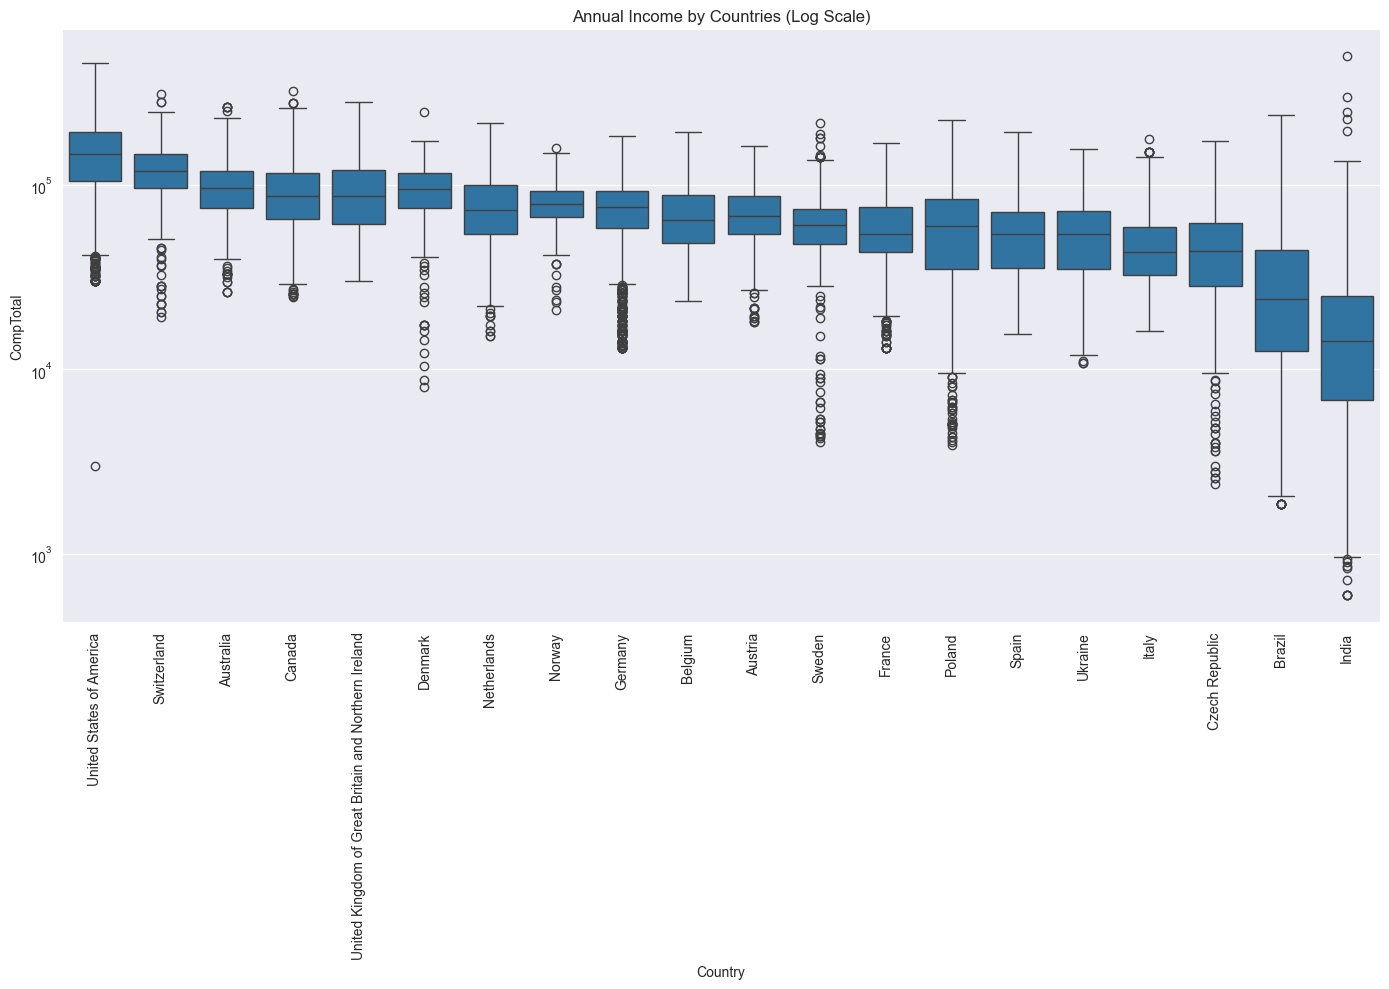

In [21]:
# generate a feature column base on YearsCodePro to indicate seniority level
df['seniority'] = pd.cut(df['YearsCodePro'].fillna(0), bins=[-0.1,1,3,7,15,50], labels=['Intern/Junior','Junior','Mid','Senior','Principal'])
WaitForOneHotEncoder.append('seniority')
# select top 20 countries which have the most data points
top_countries = df['Country'].value_counts().nlargest(20).index.tolist()

# plot boxplot of CompTotal by Country in log scale, only for top 20 countries
plt.figure(figsize=(14,10))
_tmp_df = df[df.Country.isin(top_countries)]
order = _tmp_df.groupby('Country')['CompTotal'].mean().sort_values(ascending=False).index
sns.boxplot(x='Country', y='CompTotal', data=_tmp_df, order=order,log_scale=True)
plt.xticks(rotation=90)
plt.title('Annual Income by Countries (Log Scale)')
plt.tight_layout()
plt.show()


In [22]:
# get rid of outliers in CompTotal, base on the boxplot
for country in df.Country.unique():
    log_comp = df[df.Country==country]['CompTotal'].apply(lambda x: np.log1p(x))
    Q1 = log_comp.quantile(0.25)
    Q3 = log_comp.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = log_comp[(log_comp < lower_bound) | (log_comp > upper_bound)]
    print(f'{country} start to remove outliers')
    print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}")
    print(f"Lower bound={lower_bound}, Upper bound={upper_bound}")
    print(f"Outliers count={len(outliers)}")
    print('-'*40)
    # df = df.loc[(df['CompTotal'] >= 1000) & (df['CompTotal'] <= 500000)]
    # print(df[['CompTotal']].describe())
    # remove data using the outlier bounds' index
    df = df.loc[~df.index.isin(outliers.index)]
df.reset_index(inplace=True,drop=True)

Austria start to remove outliers
Q1=10.898792771338309, Q3=11.375000659061431, IQR=0.47620788772312217
Lower bound=10.184480939753627, Upper bound=12.089312490646115
Outliers count=14
----------------------------------------
Turkey start to remove outliers
Q1=9.376496517683842, Q3=10.762727358237703, IQR=1.3862308405538606
Lower bound=7.297150256853051, Upper bound=12.842073619068493
Outliers count=17
----------------------------------------
France start to remove outliers
Q1=10.675653840146117, Q3=11.235259727793936, IQR=0.5596058876478196
Lower bound=9.836245008674387, Upper bound=12.074668559265666
Outliers count=30
----------------------------------------
United States of America start to remove outliers
Q1=11.561725152903833, Q3=12.180759965737863, IQR=0.6190348128340304
Lower bound=10.633172933652787, Upper bound=13.109312184988909
Outliers count=98
----------------------------------------
United Kingdom of Great Britain and Northern Ireland start to remove outliers
Q1=11.0243471

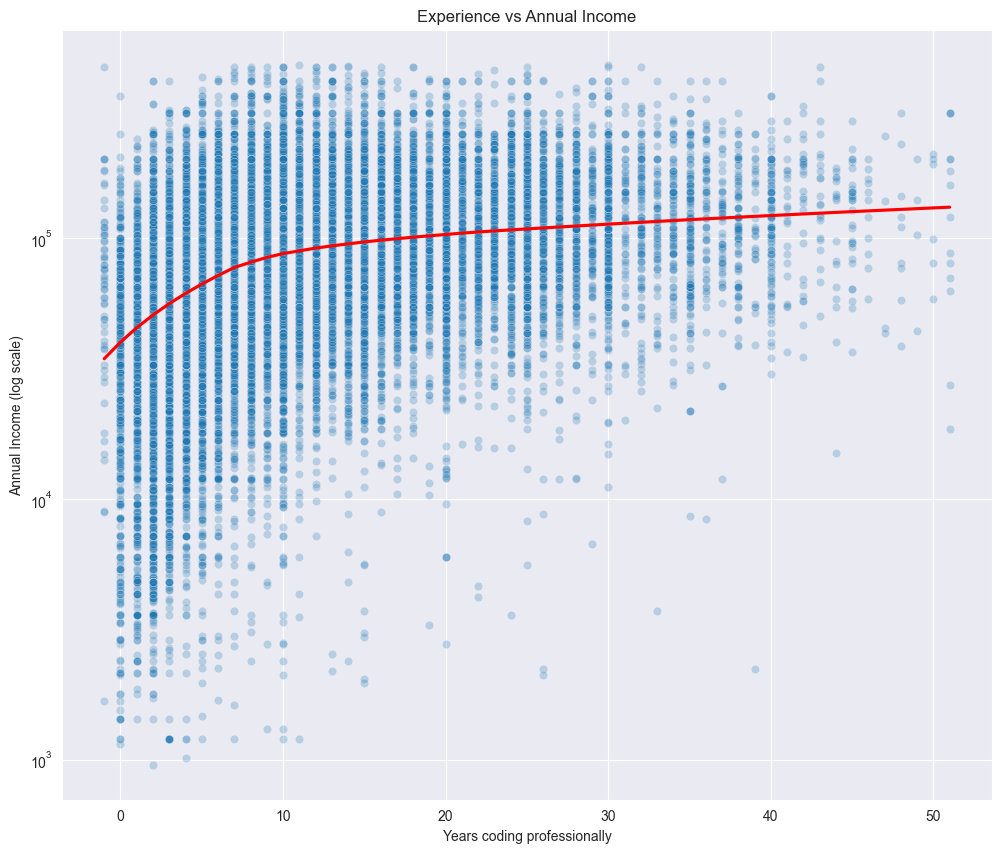

In [23]:
# check correlation between YearsCodePro and CompTotal
plt.figure(figsize=(12,10))
ax1 = sns.scatterplot(x='YearsCodePro', y='CompTotal', data=df, alpha=0.25)
ax2 = sns.regplot(x='YearsCodePro', y='CompTotal', data=df, scatter=False, lowess=True, color='red')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.xlabel('Years coding professionally')
plt.ylabel('Annual Income (log scale)')
plt.title('Experience vs Annual Income')
plt.show()


In [24]:
# Interactive choropleth: median compensation by country (log scale)
_tmp_df = df[df.Country.isin(top_countries)]
_tmp_df['logComp'] = np.log1p(df['CompTotal'])
country_median = _tmp_df.groupby('Country', as_index=False)['logComp'].median()
fig = px.choropleth(country_median, locations='Country', locationmode='country names',
                    color='logComp', hover_name='Country',
                    color_continuous_scale='thermal', title='Mean Annual Income by Country')
fig.update_layout(height=500)
fig.show()

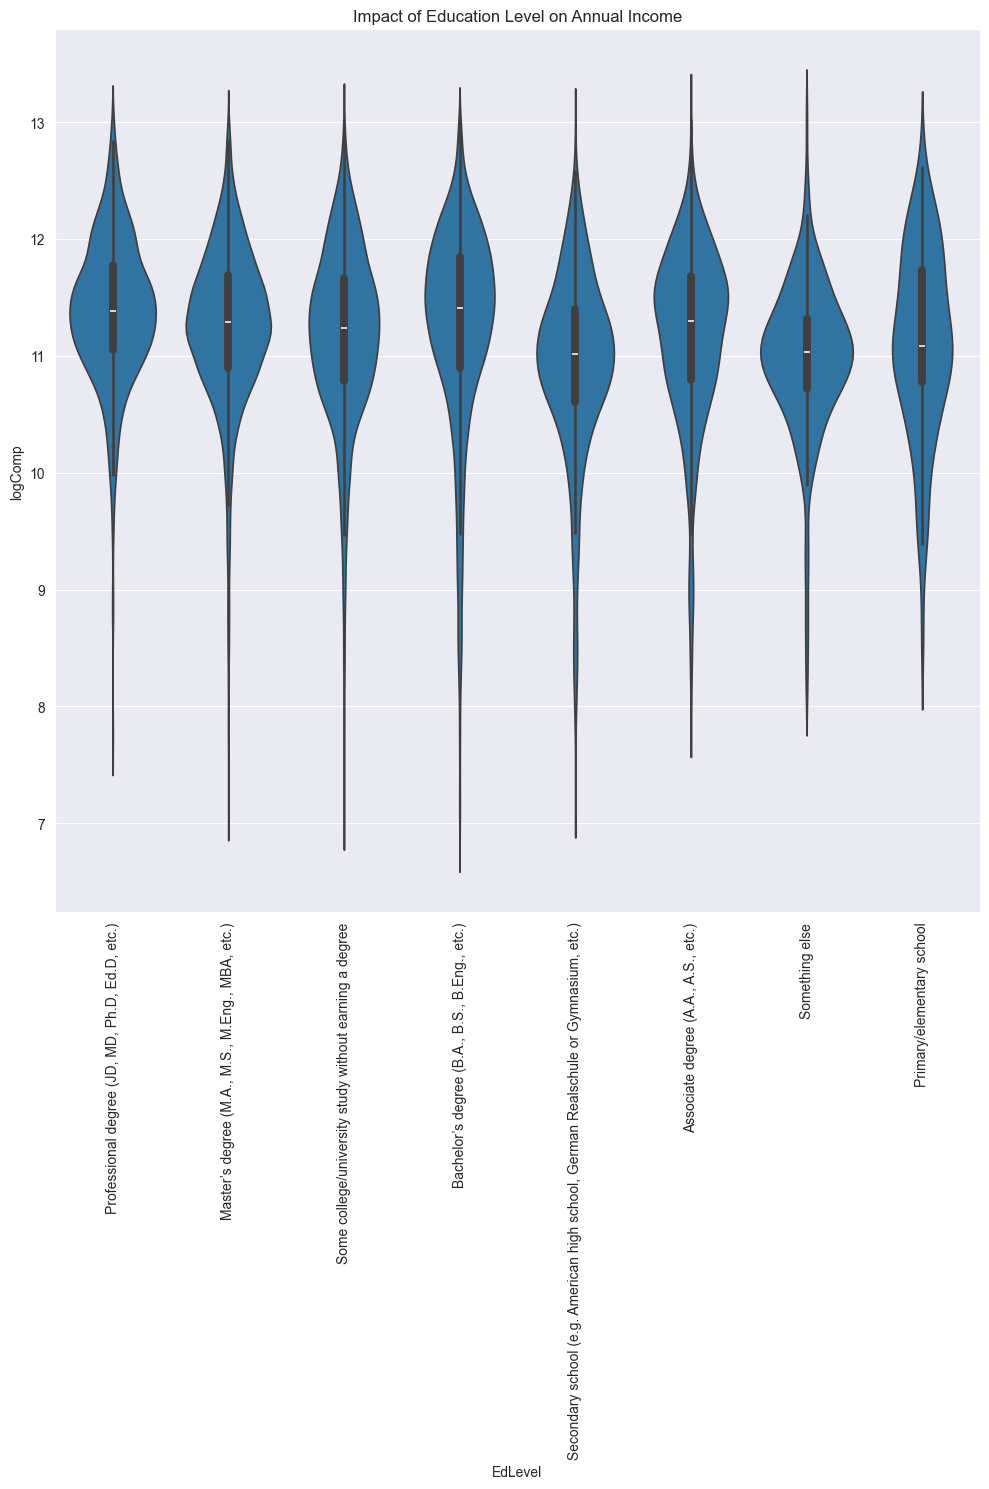

In [25]:
# check the impact of education level on salary
plt.figure(figsize=(10, 15))
sns.violinplot(data=_tmp_df, x='EdLevel', y='logComp')
plt.title('Impact of Education Level on Annual Income')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



 #As be can see, when using education level to check the salary distribution, there are some outliners, every education level has some very high salary data points, which is very reasonable, but we need to remove these outliners to make a better model.

#And yes, higher education level does not necessary means higher salary, but on average, higher education level does lead to higher salary.

In [26]:
# so by ed level, there are some outliners, we need to remove them
for edlevel in df.EdLevel.unique():
    log_comp = df[df.EdLevel==edlevel]['CompTotal'].apply(lambda x: np.log1p(x))
    Q1 = log_comp.quantile(0.25)
    Q3 = log_comp.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = log_comp[(log_comp < lower_bound) | (log_comp > upper_bound)]
    print(f'{edlevel} start to remove outliers')
    print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}")
    print(f"Lower bound={lower_bound}, Upper bound={upper_bound}")
    print(f"Outliers count={len(outliers)}")
    print('-'*40)
    # df = df.loc[(df['CompTotal'] >= 1000) & (df['CompTotal'] <= 500000)]
    # print(df[['CompTotal']].describe())
    # remove data using the outlier bounds' index
    df = df.loc[~df.index.isin(outliers.index)]
df.reset_index(inplace=True,drop=True)

Professional degree (JD, MD, Ph.D, Ed.D, etc.) start to remove outliers
Q1=10.99410127109297, Q3=11.736077016252437, IQR=0.7419757451594666
Lower bound=9.881137653353772, Upper bound=12.849040633991638
Outliers count=37
----------------------------------------
Master’s degree (M.A., M.S., M.Eng., MBA, etc.) start to remove outliers
Q1=10.898792771338309, Q3=11.640720435742814, IQR=0.7419276644045052
Lower bound=9.78590127473155, Upper bound=12.753611932349571
Outliers count=281
----------------------------------------
Some college/university study without earning a degree start to remove outliers
Q1=10.719228401304807, Q3=11.608244735642321, IQR=0.8890163343375139
Lower bound=9.385703899798536, Upper bound=12.941769237148591
Outliers count=77
----------------------------------------
Bachelor’s degree (B.A., B.S., B.Eng., etc.) start to remove outliers
Q1=10.819798284210286, Q3=11.775297421715827, IQR=0.9554991375055408
Lower bound=9.386549577951975, Upper bound=13.208546127974138
Outli

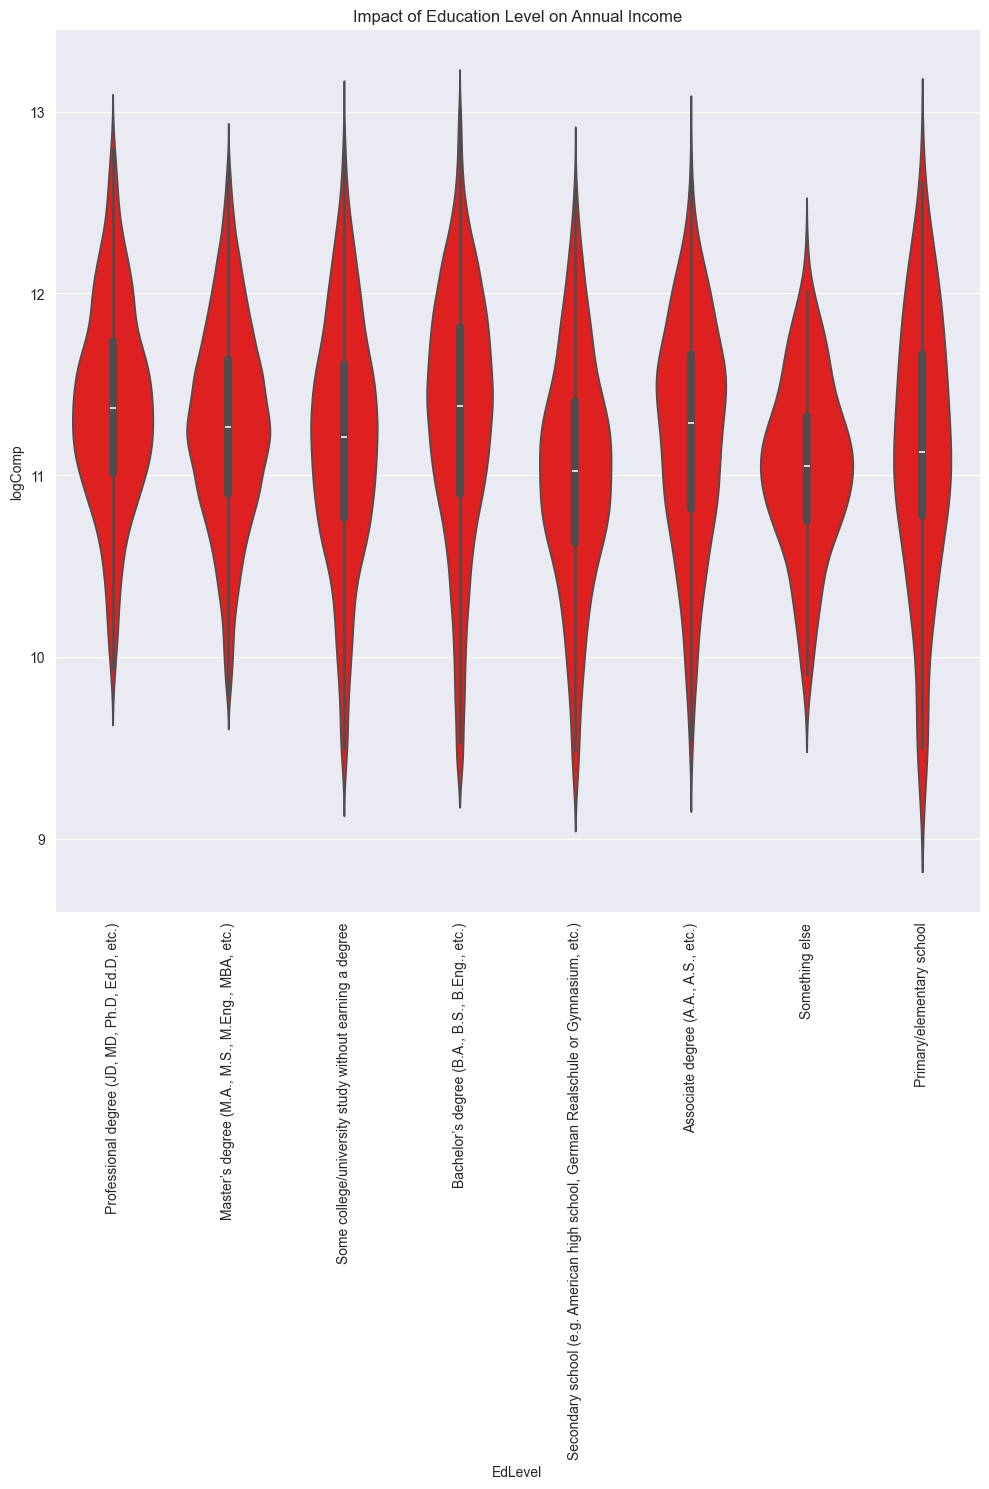

In [27]:
# check the impact of education level on salary
plt.figure(figsize=(10, 15))
_tmp_df = df.copy()
_tmp_df['logComp'] = np.log1p(df['CompTotal'])
sns.violinplot(data=_tmp_df, x='EdLevel', y='logComp', color='red')
plt.title('Impact of Education Level on Annual Income')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [28]:
basic_info('JobSatPoints_1')
# JobSatPoints_1~11 need to fillna

# it is an over all job satisfaction score from 1 to 100. total score should be 100 lets check
# !! there is no jsp_2 and jsp_3
# fillna with -1 first
for i in range(1, 12):
    if i in [2,3]:
        continue
    df[f'JobSatPoints_{i}'] = df[f'JobSatPoints_{i}'].fillna(df[f'JobSatPoints_{i}'].mode())

total_score = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].sum(axis=1)
print(total_score.value_counts())
# ok there are some value larger than 100, let's check total number
print((total_score > 100).sum())
# let try to normalize these values to 100, reverse the mistake, round to integer incase accuracy problem
df.loc[total_score > 100, [f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]] = df.loc[total_score > 100, [f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].div(total_score[total_score > 100], axis=0).multiply(100)
df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]] = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].round().astype(int)








0     NaN
1     0.0
2     NaN
3    10.0
4    40.0
Name: JobSatPoints_1, dtype: float64
----------------------------------------
25386   NaN
25387   NaN
25388   NaN
25389   NaN
25390   NaN
Name: JobSatPoints_1, dtype: float64
----------------------------------------
8415
----------------------------------------
JobSatPoints_1
0.0     6085
10.0    2633
20.0    1975
5.0      982
30.0     858
        ... 
7.5        1
66.0       1
27.0       1
78.0       1
37.0       1
Name: count, Length: 70, dtype: int64
----------------------------------------
****************************************
 100.0    11697
-9.0       8341
 0.0       2416
 99.0       117
 90.0        71
          ...  
 523.0        1
 681.0        1
 257.0        1
 532.0        1
 271.0        1
Name: count, Length: 377, dtype: int64
1957


In [29]:
total_score = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].sum(axis=1)
print(total_score.value_counts())
# ok there are some value larger than 100, let's check total number
print((total_score > 100).sum())

 100    12428
-9       8341
 0       2416
 99       577
 101      415
        ...  
 104        1
 37         1
 84         1
-5          1
 24         1
Name: count, Length: 107, dtype: int64
582


In [30]:
# check null values again
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

TechEndorse              1449
OpSysPersonal use         452
OpSysProfessional use    1688
TBranch                  1239
SurveyLength              905
SurveyEase                862
ConvertedCompYearly      8001
JobSat                   8438
seniority                  72
dtype: int64


In [31]:
drop_columns = ['TechEndorse','SurveyLength','SurveyEase','ConvertedCompYearly']
explode_columns = ['OpSysPersonal use','OpSysProfessional use']
for col in explode_columns:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')
df.drop(columns=drop_columns, inplace=True)

df['TBranch'] = df['TBranch'].map({'Yes': 1, 'No': 0})
df['TBranch'] = df['TBranch'].fillna(-1)

WaitForOneHotEncoder.append('Country')
WaitForOneHotEncoder.append('Currency')



OpSysPersonal use 24939 25391
OpSysProfessional use 23703 25391


In [32]:
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])
df
#TODO drop seniority?

JobSat       8438
seniority      72
dtype: int64


,MainBranch,Age,Employment,RemoteWork,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,...,OpSysProfessional use MacOS,OpSysProfessional use Other (please specify):,OpSysProfessional use Other Linux-based,OpSysProfessional use Red Hat,OpSysProfessional use Solaris,OpSysProfessional use Ubuntu,OpSysProfessional use Windows,OpSysProfessional use Windows Subsystem for Linux (WSL),OpSysProfessional use iOS,OpSysProfessional use iPadOS
0,"I am not primarily a developer, but I write co...",25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",12,6,Academic researcher,100 to 499 employees,I have little or no influence,...,False,False,False,False,False,True,True,False,False,False
1,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,...,True,False,False,False,False,False,False,False,False,False
2,I am a developer by profession,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,17,"Developer, back-end","Just me - I am a freelancer, sole proprietor, ...",I have a great deal of influence,...,True,False,False,False,False,False,False,False,False,False
3,I am a developer by profession,25-34 years old,"Employed, full-time;Student, part-time",Remote,Some college/university study without earning ...,7,7,Student,10 to 19 employees,I have some influence,...,False,False,False,False,False,False,False,False,False,False
4,I am a developer by profession,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",32,18,Engineering manager,"1,000 to 4,999 employees",I have little or no influence,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25386,I am a developer by profession,18-24 years old,"Employed, full-time;Independent contractor, fr...","Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",3,3,"Developer, full-stack","1,000 to 4,999 employees",I have little or no influence,...,False,False,False,False,False,False,False,False,False,False
25387,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,7,"Developer, full-stack",20 to 99 employees,I have a great deal of influence,...,False,False,True,False,False,False,True,False,False,False
25388,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",13,9,"Developer, full-stack",100 to 499 employees,I have little or no influence,...,False,False,False,False,False,False,False,False,False,False
25389,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,18,"Developer, back-end",100 to 499 employees,I have little or no influence,...,True,False,False,False,False,False,False,False,False,False


In [33]:
# replace all boolean values to 1 and 0
df.replace({True: 1, False: 0}, inplace=True)
# df

In [34]:
for train_df in df.groupby(['Country', 'Currency']):
    print(train_df[0], train_df[1].shape)

('Afghanistan', 'USD') (1, 478)
('Albania', 'EUR') (2, 478)
('Albania', 'USD') (1, 478)
('Algeria', 'USD') (2, 478)
('Andorra', 'EUR') (3, 478)
('Angola', 'USD') (1, 478)
('Antigua and Barbuda', 'AUD') (1, 478)
('Argentina', 'GBP') (1, 478)
('Argentina', 'PLN') (1, 478)
('Argentina', 'USD') (98, 478)
('Armenia', 'USD') (3, 478)
('Australia', 'AUD') (697, 478)
('Australia', 'USD') (1, 478)
('Austria', 'EUR') (457, 478)
('Azerbaijan', 'USD') (1, 478)
('Bangladesh', 'USD') (3, 478)
('Belarus', 'USD') (20, 478)
('Belgium', 'EUR') (293, 478)
('Bolivia', 'USD') (3, 478)
('Bosnia and Herzegovina', 'EUR') (3, 478)
('Botswana', 'BRL') (1, 478)
('Brazil', 'BRL') (593, 478)
('Brazil', 'CAD') (2, 478)
('Brazil', 'EUR') (5, 478)
('Brazil', 'GBP') (1, 478)
('Brazil', 'USD') (60, 478)
('Bulgaria', 'EUR') (2, 478)
('Bulgaria', 'GBP') (1, 478)
('Bulgaria', 'USD') (6, 478)
('Cambodia', 'USD') (1, 478)
('Canada', 'CAD') (1187, 478)
('Canada', 'EUR') (2, 478)
('Canada', 'USD') (16, 478)
('Chile', 'EUR') (

# we can see that some country and currency have very few data, we can filter out these data and only keep the country and currency with more than 1000 data points.


In [35]:
# finding the country and currency with more than 1000 data points
for (country,currency),train_df in df.groupby(['Country', 'Currency']):
    if train_df.shape[0]>1000:
        print(country,currency)


Canada CAD
France EUR
Germany EUR
United Kingdom of Great Britain and Northern Ireland GBP
United States of America USD


In [36]:
# check comp total distribution in these countries, in log scale
import plotly.express as px
for (country,currency), train_df in df.groupby(['Country', 'Currency']):
    if train_df.shape[0]>1000:
        print(train_df.shape)
        fig = px.histogram(
            train_df,
            x='CompTotal',
            nbins=100,  # Adjust bins for granularity
            title=f'Salary Distribution Histogram ({country}, {currency})',
            labels={'CompTotal': 'Salary Amount', 'Count': 'Number of People'},
            log_y=True  # Log scale for better visibility
        )

        fig.show()

(1187, 478)


(1228, 478)


(2650, 478)


(1905, 478)


(6588, 478)


# 🧠 Concept Check

# We are now cleaned the data, and ready for machine learning model training.
# Because the salary is in different currency, and the salary distribution is very different in different country, we will train a model for each country-currency group that has more than 1000 data points.
# We are going to test several regression models which is often used in Kaggle competitions, and a baseline dummy regressor.



Data Leakage Prevention
Job Satisfication relative column dropped
CovertedCompTotal droped before I can realise it's actually a income relative column, because it contain a lot of NaN

Throughout the data-cleaning and feature-engineering process, categorical variables were encoded after splitting and selecting relevant columns ,The target variable was never used during preprocessing or encoding, which helps avoid information from the label leaking into the model. Also, data imputation and feature transformations were done on a per-column basis before any modeling, preventing cross-sample contamination.

Evaluation Metrics
 R² (coefficient of determination),  check if model learn from the data, not just random output, of cause baseline model comparison is used
 MAE (Mean Absolute Error), average error
 RMSE (Root Mean Squared Error). penalty from larger error


Hyperparameter Tuning Rationale
Optuna was used to systematically explore model configurations such as learning rate, depth, trying to have a better performance for this dataset, and the result is a tiny little bit better than default.



AI generated code for regression model training and evaluation

In [37]:
# ====== 0. Imports ======
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    HistGradientBoostingRegressor,
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

df = df[[c for c in df.columns if "JobSat" not in c]].copy()

# df_cleaned = df.loc[df["CompTotal"] >= 1000].copy()
df_cleaned = df.copy()
# drop all JobSat

df_cleaned.dropna(inplace=True)

# ====== 1.helper: wrap a regressor with log-target transform ======
def make_log_model(reg):
    return TransformedTargetRegressor(
        regressor=reg,
        func=np.log1p,          # y -> log(1+y)
        inverse_func=np.expm1   # yhat_log -> exp(yhat_log)-1  (metrics in original units)
    )
country_result = {}
# ====== 2. Loop over each Country-Currency group ======
for (country, currency), train_df in df_cleaned.groupby(["Country", "Currency"]):
    if train_df.shape[0] < 1000:
        # print(f"Skipping group ({country}, {currency}) — too few rows ({train_df.shape[0]})")
        continue

    print(country, 'data is being processed')

    # Split features and target
    X = train_df.drop(columns=["CompTotal"])
    y = train_df["CompTotal"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identify numeric & categorical columns, we will feed them into preprocessor
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = WaitForOneHotEncoder

    # Preprocessing, here is the reason we marked some columns for one-hot encoding earlier
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    # ====== 3. Define regression models (all wrapped with log-target) ======
    models = {
        "GradientBoostingRegressor": make_log_model(GradientBoostingRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
        )),
        "RandomForestRegressor": make_log_model(RandomForestRegressor(
            n_estimators=600, random_state=42, n_jobs=-1
        )),
        "HistGradientBoostingRegressor": make_log_model(HistGradientBoostingRegressor(
            learning_rate=0.05, max_depth=None, random_state=42
        )),
        "XGBRegressor": make_log_model(XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            n_jobs=-1, random_state=42, objective="reg:squarederror"
        )),
        "LGBMRegressor": make_log_model(LGBMRegressor(
            n_estimators=800, learning_rate=0.05, num_leaves=31,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, objective="rmse", n_jobs=-1
        )),
        "LinearRegression": make_log_model(LinearRegression()),
        "Ridge": make_log_model(Ridge(alpha=1.0, random_state=42)),
        "Lasso": make_log_model(Lasso(alpha=0.001, max_iter=5000, random_state=42)),
        "HuberRegressor": make_log_model(HuberRegressor(max_iter=2000)),
        "DummyMedian": make_log_model(DummyRegressor(strategy="median")),
    }

    # ====== 4. Cross-validation config (metrics now in ORIGINAL salary units) ======
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {
        "r2": "r2",
        "neg_mae": "neg_mean_absolute_error",
        "neg_mse": "neg_mean_squared_error",
    }

    rows = []
    for name, model in models.items():
        # define a pipeline with preprocessor + model
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
        # cross-validate
        cvres = cross_validate(
            pipe, X_train, y_train,
            scoring=scoring, cv=cv, n_jobs=-1, error_score="raise"
        )

        r2 = np.mean(cvres["test_r2"]) # r2, total variance explained
        mae = -np.mean(cvres["test_neg_mae"]) # mae, mean absolute error
        rmse = np.sqrt(-np.mean(cvres["test_neg_mse"])) # rmse, root mean squared error

        rows.append({
            "Model": name,
            "CV_R2": r2,
            "CV_MAE": mae,
            "CV_RMSE": rmse,
        })
        print(f"{name:>28s} | R2={r2: .3f} | MAE={mae: .0f} | RMSE={rmse: .0f}")

    results_df = pd.DataFrame(rows).sort_values("CV_R2", ascending=False)
    best_model_name = results_df.iloc[0]["Model"]
    print(f"\nBest model (by CV R²) in ({country}, {currency}): {best_model_name}")
    print(results_df.head(5))
    country_result[country] = {'best_model': best_model_name, 'results_df': results_df}
    # ====== 5. Fit best model on train; evaluate on test ======
    best_model = models[best_model_name]
    best_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_model)])
    best_pipeline.fit(X_train, y_train)

    # Predict in ORIGINAL units (TransformedTargetRegressor handles log inverse automatically)
    y_pred = best_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))

    print(f"\n--- Test Performance ({best_model_name}) [{country}, {currency}] ---")
    print(f"R²    : {r2:.3f}")
    print(f"MAE   : {mae:,.0f}")
    print(f"RMSE  : {rmse:,.0f}")

    # ====== 6. Feature importance (tree models) or permutation importance ======
    try:
        # In our pipeline, 'model' is TransformedTargetRegressor.
        # Access the underlying fitted regressor via .regressor_
        final_ttr = best_pipeline.named_steps["model"]
        final_model = getattr(final_ttr, "regressor_", final_ttr)  # fallback if not TTR

        if hasattr(final_model, "feature_importances_"):
            try:
                feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
            except Exception:
                feature_names = [f"f{i}" for i in range(len(final_model.feature_importances_))]
            importances = final_model.feature_importances_
            top_idx = np.argsort(importances)[::-1][:30]
            print("\nTop 30 features (model importances):")
            for i in top_idx:
                print(f"{feature_names[i]:40s} {importances[i]:.6f}")
        else:
            # Permutation importance on the WHOLE pipeline (preds already in original units)
            r = permutation_importance(
                best_pipeline, X_test, y_test,
                n_repeats=5, n_jobs=-1, random_state=42, scoring="r2"
            )
            try:
                feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
            except Exception:
                feature_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]
            idx = np.argsort(r.importances_mean)[::-1][:30]
            print("\nTop 30 features (permutation importance):")
            for i in idx:
                print(f"{feature_names[i]:40s} {r.importances_mean[i]:.6f}")
    except Exception as e:
        print("\n[Feature importance skipped]", e)
# storage the country result to csv
country_result_df = pd.DataFrame(country_result)
if RUN_BY_MYSELF:
    country_result_df.to_csv('country_model_results.csv',index=False)

Canada data is being processed
   GradientBoostingRegressor | R2= 0.419 | MAE= 23409 | RMSE= 33176
       RandomForestRegressor | R2= 0.358 | MAE= 24645 | RMSE= 34906
HistGradientBoostingRegressor | R2= 0.379 | MAE= 24493 | RMSE= 34290
                XGBRegressor | R2= 0.409 | MAE= 23888 | RMSE= 33463
               LGBMRegressor | R2= 0.392 | MAE= 24257 | RMSE= 33923
            LinearRegression | R2=-25097.329 | MAE= 376183 | RMSE= 7264674
                       Ridge | R2=-15.208 | MAE= 54732 | RMSE= 182188
                       Lasso | R2=-0.129 | MAE= 31047 | RMSE= 46457
              HuberRegressor | R2=-172.698 | MAE= 95300 | RMSE= 602268
                 DummyMedian | R2=-0.037 | MAE= 32488 | RMSE= 44354

Best model (by CV R²) in (Canada, CAD): GradientBoostingRegressor
                           Model     CV_R2        CV_MAE       CV_RMSE
0      GradientBoostingRegressor  0.418982  23408.747062  33175.642006
3                   XGBRegressor  0.409162  23888.401394  33462.520

AI genarated explanation of regression metrics


### 🧮 **1️⃣ R² — Coefficient of Determination**


**Interpretation:**
- Measures how much of the variance in the target (salary) your model can explain.
- **R² = 1.0** → perfect prediction
- **R² = 0.0** → model predicts no better than the mean
- **R² < 0.0** → worse than predicting the mean

➡️ Example:
`R² = 0.44` → the model explains **44% of salary variation** in the data.

---

### 💵 **2️⃣ MAE — Mean Absolute Error**


**Interpretation:**
- The **average absolute difference** between predicted and actual salaries.
- Easy to read — same unit as the target (USD, DKK, etc.).
- **Lower = better.**

➡️ Example:
`MAE = 38,851` → predictions are off by about **\$38k on average**.

---

### 📈 **3️⃣ RMSE — Root Mean Squared Error**


**Interpretation:**
- Like MAE, but **penalizes large errors more heavily** because it squares them.
- Good indicator of how big errors can get in extreme cases.
- **Lower = better.**

➡️ Example:
`RMSE = 57,113` → the **typical deviation** between predictions and actual salaries is about **\$57k**.

---

### 📘 **Comparison Table**

| Metric | Unit | Penalizes Large Errors? | Interpretation | Best Value |
|:-------|:------|:------------------------|:---------------|:------------|
| **R²** | None | ❌ | % of explained variance | **1.0** |
| **MAE** | Same as target | ❌ | Average absolute error | **0** |
| **RMSE** | Same as target | ✅ | Typical weighted error (sensitive to outliers) | **0** |

---

### ✅ **Summary Example (from your model)**

| Metric | Value | Meaning |
|:--------|:--------|:---------|
| **R²** | 0.44 | Model explains 44% of salary variation |
| **MAE** | 38,851 | Average prediction error ≈ \$38k |
| **RMSE** | 57,113 | Typical deviation ≈ \$57k (due to outliers) |

---

**In short:**
> LightGBM model explains about **44%** of salary variance,
> predicts within **\$39k** on average,
> and its larger misses are around **\$57k** —
> which is strong performance for a noisy, real-world salary dataset.

AI helped in this train process

In [38]:
# =========================
# USA-only salary regression — XGBRegressor + Optuna fine-tune
# =========================

import warnings
import numpy as np
import pandas as pd
import optuna

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# =====================================
# 0) Filter to USA (and USD if desired)
# =====================================
# df must already exist.
# get rid of column contain JobSat
df = df[[c for c in df.columns if "JobSat" not in c]].copy()
usa = df[(df["Country"] == "United States of America") & (df["Currency"] == "USD")].copy()
# If you don't want to filter currency, use: usa = df[df["Country"] == "United States of America"].copy()
usa = usa[usa["CompTotal"] >= 1000].dropna()

print(f"USA rows: {len(usa)}")

# ================
# 1) Train/test split
# ================
X = usa.drop(columns=["CompTotal"])
y = usa["CompTotal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ======================================
# 2) Preprocessing (numeric + categorical)
# ======================================
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # older scikit-learn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ===========================
# 3) Log-target wrapper
# ===========================
def make_log(reg):
    return TransformedTargetRegressor(
        regressor=reg, func=np.log1p, inverse_func=np.expm1
    )

# ===========================
# 4) Baseline XGB pipeline
# ===========================
def make_pipeline(xgb_params: dict):
    reg = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        tree_method="hist",  # fast & robust default
        **xgb_params
    )
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", make_log(reg)),
    ])
    return pipe

# ===========================
# 5) Optuna objective
# ===========================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
SCORING = {"r2":"r2", "neg_mae":"neg_mean_absolute_error", "neg_mse":"neg_mean_squared_error"}

def objective(trial: optuna.Trial) -> float:
    # Reasonable XGB search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 600, 1500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.10, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 8.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "max_bin": trial.suggest_int("max_bin", 128, 512, step=64),  # used by 'hist'
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        # Note: early_stopping not used inside CV to avoid leakage/complications with Pipeline
    }

    pipe = make_pipeline(params)

    # Cross-validated R^2 on training split (maximize)
    cvres = cross_validate(pipe, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=-1)
    mean_r2 = float(np.mean(cvres["test_r2"]))
    trial.report(mean_r2, step=0)
    return mean_r2

# ===========================
# 6) Run study
# ===========================
study = optuna.create_study(direction="maximize", study_name="xgb_salary_usa")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n[USA] Best trial:", study.best_trial.number)
print("[USA] Best R² (CV):", round(study.best_value, 4))
print("[USA] Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# ===========================
# 7) Fit best pipeline on train and evaluate on test
# ===========================
best_params = study.best_params.copy()
best_pipeline = make_pipeline(best_params)
best_pipeline.fit(X_train, y_train)

# Test evaluation
y_pred = best_pipeline.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"\n--- Test Performance (XGBRegressor[OPTUNA_USA]) [USA, USD] ---")
print(f"R²    : {r2:.3f}")
print(f"MAE   : {mae:,.0f}")
print(f"RMSE  : {rmse:,.0f}")

# ===========================
# 8) Feature importances (top 30)
# ===========================
try:
    final_ttr = best_pipeline.named_steps["model"]
    final_model = getattr(final_ttr, "regressor_", final_ttr)

    if hasattr(final_model, "feature_importances_"):
        try:
            feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
        except Exception:
            feature_names = [f"f{i}" for i in range(len(final_model.feature_importances_))]
        importances = final_model.feature_importances_
        top_idx = np.argsort(importances)[::-1][:30]
        print("\nTop 30 features (model importances):")
        for i in top_idx:
            print(f"{feature_names[i]:40s} {importances[i]:.6f}")
    else:
        # Fallback: permutation importance (slower)
        from sklearn.inspection import permutation_importance
        r = permutation_importance(
            best_pipeline, X_test, y_test,
            n_repeats=5, n_jobs=-1, random_state=42, scoring="r2"
        )
        try:
            feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
        except Exception:
            feature_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]
        idx = np.argsort(r.importances_mean)[::-1][:30]
        print("\nTop 30 features (permutation importance):")
        for i in idx:
            print(f"{feature_names[i]:40s} {r.importances_mean[i]:.6f}")
except Exception as e:
    print("\n[Feature importance skipped]", e)

# ===========================
# 9) Optional: Save Optuna artifacts
# ===========================
optuna.importance.get_param_importances(study)  # to inspect param influence
if RUN_BY_MYSELF:
    study.trials_dataframe().to_csv("optuna_xgb_trials.csv", index=False)


[I 2025-10-09 16:23:58,072] A new study created in memory with name: xgb_salary_usa


USA rows: 6563


Best trial: 0. Best value: 0.330039:   2%|▏         | 1/50 [00:09<07:48,  9.57s/it]

[I 2025-10-09 16:24:07,636] Trial 0 finished with value: 0.33003909903985473 and parameters: {'n_estimators': 900, 'learning_rate': 0.02024358407380564, 'max_depth': 4, 'min_child_weight': 5.570383648609905, 'subsample': 0.6657933430182187, 'colsample_bytree': 0.6340415047813664, 'gamma': 2.7690897791859843, 'reg_alpha': 1.8530276531241592, 'reg_lambda': 2.910688553007393, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.33003909903985473.


Best trial: 1. Best value: 0.338237:   4%|▍         | 2/50 [00:16<06:15,  7.83s/it]

[I 2025-10-09 16:24:14,250] Trial 1 finished with value: 0.33823749695064825 and parameters: {'n_estimators': 700, 'learning_rate': 0.07877037060408582, 'max_depth': 7, 'min_child_weight': 4.551605902643079, 'subsample': 0.8338185485293667, 'colsample_bytree': 0.7732896615169482, 'gamma': 2.96024416987368, 'reg_alpha': 1.2884464387815229, 'reg_lambda': 1.5425276556548164, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.33823749695064825.


Best trial: 1. Best value: 0.338237:   6%|▌         | 3/50 [00:26<07:02,  8.99s/it]

[I 2025-10-09 16:24:24,614] Trial 2 finished with value: 0.3303683463667214 and parameters: {'n_estimators': 1400, 'learning_rate': 0.06595113907858455, 'max_depth': 11, 'min_child_weight': 5.007111948594082, 'subsample': 0.9711333833277118, 'colsample_bytree': 0.8259448884159766, 'gamma': 3.162631556716578, 'reg_alpha': 0.17914989527128955, 'reg_lambda': 2.145820909760953, 'max_bin': 448, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.33823749695064825.


Best trial: 3. Best value: 0.349275:   8%|▊         | 4/50 [00:33<06:19,  8.25s/it]

[I 2025-10-09 16:24:31,743] Trial 3 finished with value: 0.3492745747833609 and parameters: {'n_estimators': 800, 'learning_rate': 0.020551669574416332, 'max_depth': 5, 'min_child_weight': 2.1676722658071683, 'subsample': 0.7675780077631351, 'colsample_bytree': 0.6432237551112111, 'gamma': 2.1088287335818077, 'reg_alpha': 2.171791030822409, 'reg_lambda': 1.055638839348163, 'max_bin': 256, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.3492745747833609.


Best trial: 3. Best value: 0.349275:  10%|█         | 5/50 [00:41<05:58,  7.97s/it]

[I 2025-10-09 16:24:39,224] Trial 4 finished with value: 0.301900103472335 and parameters: {'n_estimators': 1000, 'learning_rate': 0.056692096097704175, 'max_depth': 10, 'min_child_weight': 3.4078237231681188, 'subsample': 0.7687319237566187, 'colsample_bytree': 0.7447327432394792, 'gamma': 4.9891145983515885, 'reg_alpha': 0.33315742835586837, 'reg_lambda': 2.2023926809590284, 'max_bin': 256, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.3492745747833609.


Best trial: 5. Best value: 0.430482:  12%|█▏        | 6/50 [00:49<05:54,  8.07s/it]

[I 2025-10-09 16:24:47,464] Trial 5 finished with value: 0.4304819156727941 and parameters: {'n_estimators': 900, 'learning_rate': 0.04578272116151755, 'max_depth': 6, 'min_child_weight': 5.144942407424174, 'subsample': 0.6316759343667108, 'colsample_bytree': 0.7139715753220869, 'gamma': 0.36709322769744035, 'reg_alpha': 1.0002028290554157, 'reg_lambda': 1.4974951200699302, 'max_bin': 512, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.4304819156727941.


Best trial: 5. Best value: 0.430482:  14%|█▍        | 7/50 [00:55<05:21,  7.48s/it]

[I 2025-10-09 16:24:53,740] Trial 6 finished with value: 0.4096437944146126 and parameters: {'n_estimators': 600, 'learning_rate': 0.0367528744668727, 'max_depth': 6, 'min_child_weight': 7.170142188512982, 'subsample': 0.9276514639548462, 'colsample_bytree': 0.6908026298703478, 'gamma': 0.43253718537882013, 'reg_alpha': 2.979408868626913, 'reg_lambda': 1.465077025910949, 'max_bin': 384, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.4304819156727941.


Best trial: 5. Best value: 0.430482:  16%|█▌        | 8/50 [01:04<05:32,  7.92s/it]

[I 2025-10-09 16:25:02,614] Trial 7 finished with value: 0.392484903422586 and parameters: {'n_estimators': 1200, 'learning_rate': 0.058435960139172356, 'max_depth': 12, 'min_child_weight': 1.7362289873430874, 'subsample': 0.9294852637860372, 'colsample_bytree': 0.9452424044095636, 'gamma': 0.9470855335470335, 'reg_alpha': 0.7187493892149496, 'reg_lambda': 0.08022070920323143, 'max_bin': 128, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.4304819156727941.


Best trial: 5. Best value: 0.430482:  18%|█▊        | 9/50 [01:15<06:02,  8.85s/it]

[I 2025-10-09 16:25:13,489] Trial 8 finished with value: 0.3736028921435948 and parameters: {'n_estimators': 1300, 'learning_rate': 0.02021225050116414, 'max_depth': 6, 'min_child_weight': 3.980776609530479, 'subsample': 0.9730032654507887, 'colsample_bytree': 0.9897597879261373, 'gamma': 1.0729877097489882, 'reg_alpha': 2.9949776800013908, 'reg_lambda': 1.7038243149281684, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.4304819156727941.


Best trial: 5. Best value: 0.430482:  20%|██        | 10/50 [01:26<06:15,  9.39s/it]

[I 2025-10-09 16:25:24,083] Trial 9 finished with value: 0.4066788576680671 and parameters: {'n_estimators': 1400, 'learning_rate': 0.061384544371389134, 'max_depth': 11, 'min_child_weight': 7.1588468492785395, 'subsample': 0.6417330384817616, 'colsample_bytree': 0.8191234722738061, 'gamma': 0.7265434450215585, 'reg_alpha': 2.74283252520267, 'reg_lambda': 0.9435089076285511, 'max_bin': 448, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.4304819156727941.


Best trial: 5. Best value: 0.430482:  22%|██▏       | 11/50 [01:47<08:24, 12.95s/it]

[I 2025-10-09 16:25:45,103] Trial 10 finished with value: 0.42852939519211725 and parameters: {'n_estimators': 1100, 'learning_rate': 0.03632792910431845, 'max_depth': 9, 'min_child_weight': 5.984775673378353, 'subsample': 0.6989659331114025, 'colsample_bytree': 0.8820307522804156, 'gamma': 0.002789549891580534, 'reg_alpha': 1.0412761739726133, 'reg_lambda': 0.19633463085012304, 'max_bin': 512, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.4304819156727941.


Best trial: 11. Best value: 0.434577:  24%|██▍       | 12/50 [01:59<08:04, 12.74s/it]

[I 2025-10-09 16:25:57,373] Trial 11 finished with value: 0.4345774645593433 and parameters: {'n_estimators': 1100, 'learning_rate': 0.0363228220121803, 'max_depth': 9, 'min_child_weight': 5.885202654259335, 'subsample': 0.6990710935926888, 'colsample_bytree': 0.8895833453454759, 'gamma': 0.0716879258800911, 'reg_alpha': 1.1316872333543606, 'reg_lambda': 0.20064047585092665, 'max_bin': 512, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.4345774645593433.


Best trial: 11. Best value: 0.434577:  26%|██▌       | 13/50 [02:07<06:59, 11.34s/it]

[I 2025-10-09 16:26:05,508] Trial 12 finished with value: 0.37309218802783084 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03970278361572032, 'max_depth': 8, 'min_child_weight': 6.082781012093274, 'subsample': 0.6006610372614473, 'colsample_bytree': 0.8820198647398948, 'gamma': 1.6446116630939973, 'reg_alpha': 1.6371148290912978, 'reg_lambda': 0.5986809298744895, 'max_bin': 512, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.4345774645593433.


Best trial: 11. Best value: 0.434577:  28%|██▊       | 14/50 [02:15<06:16, 10.46s/it]

[I 2025-10-09 16:26:13,927] Trial 13 finished with value: 0.3140823530654491 and parameters: {'n_estimators': 1100, 'learning_rate': 0.028817883574565748, 'max_depth': 8, 'min_child_weight': 7.849789087062806, 'subsample': 0.7151450081775761, 'colsample_bytree': 0.7026716355061482, 'gamma': 4.023610778573125, 'reg_alpha': 0.8211977268262334, 'reg_lambda': 0.6327448159730352, 'max_bin': 512, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.4345774645593433.


Best trial: 14. Best value: 0.436189:  30%|███       | 15/50 [02:29<06:39, 11.42s/it]

[I 2025-10-09 16:26:27,583] Trial 14 finished with value: 0.43618917538819435 and parameters: {'n_estimators': 800, 'learning_rate': 0.028576201104618518, 'max_depth': 9, 'min_child_weight': 3.6500228695094075, 'subsample': 0.6079455637025735, 'colsample_bytree': 0.8868968799567081, 'gamma': 0.042182368117196375, 'reg_alpha': 1.3883225367003542, 'reg_lambda': 2.813087196410826, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.43618917538819435.


Best trial: 14. Best value: 0.436189:  32%|███▏      | 16/50 [02:35<05:35,  9.87s/it]

[I 2025-10-09 16:26:33,848] Trial 15 finished with value: 0.36980003362718933 and parameters: {'n_estimators': 600, 'learning_rate': 0.028641474122680134, 'max_depth': 9, 'min_child_weight': 2.9161174245624726, 'subsample': 0.7129397584450503, 'colsample_bytree': 0.8918540559850878, 'gamma': 1.5027914254609898, 'reg_alpha': 2.1388288784534866, 'reg_lambda': 2.900406083714527, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.43618917538819435.


Best trial: 14. Best value: 0.436189:  34%|███▍      | 17/50 [02:43<05:06,  9.28s/it]

[I 2025-10-09 16:26:41,767] Trial 16 finished with value: 0.35810094515901886 and parameters: {'n_estimators': 800, 'learning_rate': 0.028377410697572127, 'max_depth': 9, 'min_child_weight': 1.0780587770717722, 'subsample': 0.8327333425808334, 'colsample_bytree': 0.9414642985012428, 'gamma': 2.045450669870344, 'reg_alpha': 1.3983592711625261, 'reg_lambda': 2.2441979437607587, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.43618917538819435.


Best trial: 17. Best value: 0.437055:  36%|███▌      | 18/50 [03:04<06:45, 12.66s/it]

[I 2025-10-09 16:27:02,275] Trial 17 finished with value: 0.4370551242696249 and parameters: {'n_estimators': 1500, 'learning_rate': 0.025251120954040675, 'max_depth': 10, 'min_child_weight': 3.9332104822401677, 'subsample': 0.6007506148827465, 'colsample_bytree': 0.8445789965522053, 'gamma': 0.04198171491418221, 'reg_alpha': 0.4956469068713534, 'reg_lambda': 2.648448096148186, 'max_bin': 128, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.4370551242696249.


Best trial: 17. Best value: 0.437055:  38%|███▊      | 19/50 [03:15<06:20, 12.28s/it]

[I 2025-10-09 16:27:13,662] Trial 18 finished with value: 0.3982340227291719 and parameters: {'n_estimators': 1500, 'learning_rate': 0.024901686332448693, 'max_depth': 12, 'min_child_weight': 3.5508537582355246, 'subsample': 0.6156237546447002, 'colsample_bytree': 0.8417400445131604, 'gamma': 1.1601851875921467, 'reg_alpha': 0.6032652307989763, 'reg_lambda': 2.597887083791686, 'max_bin': 128, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.4370551242696249.


Best trial: 17. Best value: 0.437055:  40%|████      | 20/50 [03:26<05:57, 11.90s/it]

[I 2025-10-09 16:27:24,694] Trial 19 finished with value: 0.33075998933606254 and parameters: {'n_estimators': 1500, 'learning_rate': 0.024914223089922447, 'max_depth': 10, 'min_child_weight': 2.529574841664837, 'subsample': 0.7608939967836754, 'colsample_bytree': 0.7754557971407258, 'gamma': 3.4993991464806617, 'reg_alpha': 0.05928868938875009, 'reg_lambda': 2.5641108500317658, 'max_bin': 192, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.4370551242696249.


Best trial: 17. Best value: 0.437055:  42%|████▏     | 21/50 [03:36<05:25, 11.22s/it]

[I 2025-10-09 16:27:34,330] Trial 20 finished with value: 0.36179772501814106 and parameters: {'n_estimators': 1300, 'learning_rate': 0.046394574173964885, 'max_depth': 10, 'min_child_weight': 4.155654349469998, 'subsample': 0.6678282935131781, 'colsample_bytree': 0.9369698271936722, 'gamma': 2.282285670336776, 'reg_alpha': 0.4769480582199401, 'reg_lambda': 1.877544472343296, 'max_bin': 192, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.4370551242696249.


Best trial: 17. Best value: 0.437055:  44%|████▍     | 22/50 [03:53<06:01, 12.92s/it]

[I 2025-10-09 16:27:51,220] Trial 21 finished with value: 0.43448145548328654 and parameters: {'n_estimators': 1200, 'learning_rate': 0.03339168716831874, 'max_depth': 9, 'min_child_weight': 4.536499680374035, 'subsample': 0.6647985965964456, 'colsample_bytree': 0.857493646588425, 'gamma': 0.026824098238096727, 'reg_alpha': 1.2139264955500422, 'reg_lambda': 2.5111832209328853, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.4370551242696249.


Best trial: 17. Best value: 0.437055:  46%|████▌     | 23/50 [04:01<05:10, 11.49s/it]

[I 2025-10-09 16:27:59,370] Trial 22 finished with value: 0.42341536822915254 and parameters: {'n_estimators': 800, 'learning_rate': 0.02500066030651931, 'max_depth': 11, 'min_child_weight': 6.426444059543962, 'subsample': 0.6024729696541181, 'colsample_bytree': 0.9104971709946811, 'gamma': 0.48607033779804804, 'reg_alpha': 1.5325101839742925, 'reg_lambda': 2.905654395071455, 'max_bin': 256, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.4370551242696249.


Best trial: 23. Best value: 0.438851:  48%|████▊     | 24/50 [04:12<04:57, 11.45s/it]

[I 2025-10-09 16:28:10,730] Trial 23 finished with value: 0.43885061756342025 and parameters: {'n_estimators': 900, 'learning_rate': 0.03241042941013831, 'max_depth': 7, 'min_child_weight': 3.2755832892411494, 'subsample': 0.7036839023204873, 'colsample_bytree': 0.9949805926440659, 'gamma': 0.0770023001059782, 'reg_alpha': 0.9032569132249618, 'reg_lambda': 1.953092417892968, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  50%|█████     | 25/50 [04:19<04:13, 10.14s/it]

[I 2025-10-09 16:28:17,810] Trial 24 finished with value: 0.4204815411009254 and parameters: {'n_estimators': 700, 'learning_rate': 0.028808078760555494, 'max_depth': 7, 'min_child_weight': 3.159382395002211, 'subsample': 0.6455214406663772, 'colsample_bytree': 0.9935280589339412, 'gamma': 0.5720163233057621, 'reg_alpha': 0.8021723067180937, 'reg_lambda': 2.033853527206105, 'max_bin': 192, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  52%|█████▏    | 26/50 [04:26<03:41,  9.23s/it]

[I 2025-10-09 16:28:24,932] Trial 25 finished with value: 0.37716397534893215 and parameters: {'n_estimators': 900, 'learning_rate': 0.09853112063210297, 'max_depth': 8, 'min_child_weight': 3.9638536322747147, 'subsample': 0.736875696070936, 'colsample_bytree': 0.9666107939065316, 'gamma': 1.60926765845963, 'reg_alpha': 1.8089906137049356, 'reg_lambda': 2.3912767564029638, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  54%|█████▍    | 27/50 [04:33<03:11,  8.33s/it]

[I 2025-10-09 16:28:31,164] Trial 26 finished with value: 0.3934212143591158 and parameters: {'n_estimators': 700, 'learning_rate': 0.032248345517270495, 'max_depth': 7, 'min_child_weight': 2.703343035322952, 'subsample': 0.6626298441999426, 'colsample_bytree': 0.7904971756627391, 'gamma': 1.2324966441896263, 'reg_alpha': 0.4337057379919227, 'reg_lambda': 2.7163761170929726, 'max_bin': 128, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  56%|█████▌    | 28/50 [04:42<03:10,  8.67s/it]

[I 2025-10-09 16:28:40,608] Trial 27 finished with value: 0.4094705601829604 and parameters: {'n_estimators': 1000, 'learning_rate': 0.023097994816649568, 'max_depth': 10, 'min_child_weight': 1.9282226012097798, 'subsample': 0.6826804931313681, 'colsample_bytree': 0.9214178714907051, 'gamma': 0.8107225438115195, 'reg_alpha': 0.8921120769368251, 'reg_lambda': 1.9144748331240347, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  58%|█████▊    | 29/50 [04:52<03:08,  8.96s/it]

[I 2025-10-09 16:28:50,261] Trial 28 finished with value: 0.43499886944078037 and parameters: {'n_estimators': 900, 'learning_rate': 0.023154351317531362, 'max_depth': 7, 'min_child_weight': 3.6690988444826713, 'subsample': 0.6230349623636167, 'colsample_bytree': 0.8597669927915451, 'gamma': 0.2963127486094472, 'reg_alpha': 0.61440250089592, 'reg_lambda': 2.4112927223650775, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  60%|██████    | 30/50 [04:58<02:43,  8.16s/it]

[I 2025-10-09 16:28:56,564] Trial 29 finished with value: 0.3393750601186585 and parameters: {'n_estimators': 800, 'learning_rate': 0.041341991987449124, 'max_depth': 4, 'min_child_weight': 4.84871813287356, 'subsample': 0.8043792553268903, 'colsample_bytree': 0.9665867087233567, 'gamma': 2.519136707475253, 'reg_alpha': 2.136165865208853, 'reg_lambda': 2.981505627207366, 'max_bin': 256, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  62%|██████▏   | 31/50 [05:07<02:41,  8.51s/it]

[I 2025-10-09 16:29:05,881] Trial 30 finished with value: 0.29968081524680035 and parameters: {'n_estimators': 1200, 'learning_rate': 0.03271301797814557, 'max_depth': 5, 'min_child_weight': 1.3713850217709944, 'subsample': 0.6440806953192522, 'colsample_bytree': 0.8087208745641774, 'gamma': 4.3856747356955355, 'reg_alpha': 1.7810755817539428, 'reg_lambda': 2.740143758574865, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  64%|██████▍   | 32/50 [05:19<02:51,  9.51s/it]

[I 2025-10-09 16:29:17,723] Trial 31 finished with value: 0.4329815707072392 and parameters: {'n_estimators': 900, 'learning_rate': 0.022647387846307116, 'max_depth': 7, 'min_child_weight': 3.6853892722442576, 'subsample': 0.6208747528086239, 'colsample_bytree': 0.857232112630457, 'gamma': 0.313852720931618, 'reg_alpha': 0.6384911403027614, 'reg_lambda': 2.371482292497708, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  66%|██████▌   | 33/50 [05:32<02:56, 10.37s/it]

[I 2025-10-09 16:29:30,103] Trial 32 finished with value: 0.43419542123445165 and parameters: {'n_estimators': 900, 'learning_rate': 0.022714130901599315, 'max_depth': 8, 'min_child_weight': 4.2442024170362975, 'subsample': 0.6012474296488937, 'colsample_bytree': 0.8444188216860145, 'gamma': 0.3215206355880159, 'reg_alpha': 0.29093466641152443, 'reg_lambda': 2.7124718531587595, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 23. Best value: 0.438851:  68%|██████▊   | 34/50 [05:43<02:50, 10.65s/it]

[I 2025-10-09 16:29:41,393] Trial 33 finished with value: 0.41356185348802904 and parameters: {'n_estimators': 1000, 'learning_rate': 0.026431547319394424, 'max_depth': 8, 'min_child_weight': 3.1855433684680845, 'subsample': 0.6302770051835984, 'colsample_bytree': 0.865737193250796, 'gamma': 0.7049607496196018, 'reg_alpha': 1.3590605355027183, 'reg_lambda': 2.353793720022129, 'max_bin': 192, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.43885061756342025.


Best trial: 34. Best value: 0.439168:  70%|███████   | 35/50 [05:54<02:41, 10.79s/it]

[I 2025-10-09 16:29:52,513] Trial 34 finished with value: 0.4391677634249599 and parameters: {'n_estimators': 800, 'learning_rate': 0.03169545359148246, 'max_depth': 7, 'min_child_weight': 5.417905369296552, 'subsample': 0.6830685460976255, 'colsample_bytree': 0.7452237342754822, 'gamma': 0.19925103762844776, 'reg_alpha': 0.5555739456904022, 'reg_lambda': 1.7696984074069206, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  72%|███████▏  | 36/50 [06:04<02:28, 10.59s/it]

[I 2025-10-09 16:30:02,645] Trial 35 finished with value: 0.4389815746978796 and parameters: {'n_estimators': 700, 'learning_rate': 0.032252200491863954, 'max_depth': 6, 'min_child_weight': 5.099616969174505, 'subsample': 0.7378648770496593, 'colsample_bytree': 0.7548318534824373, 'gamma': 0.16647894896532253, 'reg_alpha': 0.015562670892158292, 'reg_lambda': 1.130328246930467, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  74%|███████▍  | 37/50 [06:12<02:07,  9.81s/it]

[I 2025-10-09 16:30:10,623] Trial 36 finished with value: 0.4079923994507243 and parameters: {'n_estimators': 700, 'learning_rate': 0.051594773911096466, 'max_depth': 5, 'min_child_weight': 5.34741487781484, 'subsample': 0.7456737567271738, 'colsample_bytree': 0.7485993875017629, 'gamma': 0.8688239011654346, 'reg_alpha': 0.03537474117791578, 'reg_lambda': 1.1131826535886402, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  76%|███████▌  | 38/50 [06:20<01:49,  9.12s/it]

[I 2025-10-09 16:30:18,153] Trial 37 finished with value: 0.38637315578242093 and parameters: {'n_estimators': 600, 'learning_rate': 0.03228001914164501, 'max_depth': 6, 'min_child_weight': 4.859957764946835, 'subsample': 0.799786011518861, 'colsample_bytree': 0.648287326514736, 'gamma': 1.319374542652044, 'reg_alpha': 0.2281204591764936, 'reg_lambda': 1.2298343224129737, 'max_bin': 384, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  78%|███████▊  | 39/50 [06:27<01:35,  8.65s/it]

[I 2025-10-09 16:30:25,698] Trial 38 finished with value: 0.3405312386125769 and parameters: {'n_estimators': 700, 'learning_rate': 0.04288341377968342, 'max_depth': 6, 'min_child_weight': 5.3939446630119665, 'subsample': 0.7295136872446932, 'colsample_bytree': 0.7332320095168329, 'gamma': 2.9528115078100785, 'reg_alpha': 0.3972944411025678, 'reg_lambda': 1.3374928544081435, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  80%|████████  | 40/50 [06:36<01:27,  8.71s/it]

[I 2025-10-09 16:30:34,546] Trial 39 finished with value: 0.417036200497474 and parameters: {'n_estimators': 800, 'learning_rate': 0.0384384979065645, 'max_depth': 4, 'min_child_weight': 6.521836579989111, 'subsample': 0.7835574382573204, 'colsample_bytree': 0.6815770600497768, 'gamma': 0.6027157469670328, 'reg_alpha': 0.12614417346000034, 'reg_lambda': 1.6684251785652267, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  82%|████████▏ | 41/50 [06:43<01:12,  8.08s/it]

[I 2025-10-09 16:30:41,160] Trial 40 finished with value: 0.3666089012357782 and parameters: {'n_estimators': 600, 'learning_rate': 0.07050895940904416, 'max_depth': 5, 'min_child_weight': 4.549350685494495, 'subsample': 0.8721107421527948, 'colsample_bytree': 0.7546239815792323, 'gamma': 1.9006210526047844, 'reg_alpha': 0.5148901977145769, 'reg_lambda': 1.6896925494138788, 'max_bin': 448, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  84%|████████▍ | 42/50 [06:53<01:11,  8.90s/it]

[I 2025-10-09 16:30:51,986] Trial 41 finished with value: 0.4372659845086882 and parameters: {'n_estimators': 800, 'learning_rate': 0.030613132245113882, 'max_depth': 7, 'min_child_weight': 2.3069938444497184, 'subsample': 0.6770148017131407, 'colsample_bytree': 0.7744120353377089, 'gamma': 0.21779038740994994, 'reg_alpha': 0.8942918770333619, 'reg_lambda': 2.047765770238792, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  86%|████████▌ | 43/50 [07:03<01:03,  9.09s/it]

[I 2025-10-09 16:31:01,524] Trial 42 finished with value: 0.4334945146675232 and parameters: {'n_estimators': 700, 'learning_rate': 0.03512793592720587, 'max_depth': 7, 'min_child_weight': 2.1355764878265124, 'subsample': 0.6876279351208942, 'colsample_bytree': 0.7731382747573036, 'gamma': 0.27959330438464786, 'reg_alpha': 0.9502881278079535, 'reg_lambda': 2.0535026023417426, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  88%|████████▊ | 44/50 [07:13<00:55,  9.30s/it]

[I 2025-10-09 16:31:11,320] Trial 43 finished with value: 0.437959362986957 and parameters: {'n_estimators': 700, 'learning_rate': 0.031007788666157637, 'max_depth': 6, 'min_child_weight': 2.4037601418244727, 'subsample': 0.7244228229799281, 'colsample_bytree': 0.7318533042600137, 'gamma': 0.2168662332409558, 'reg_alpha': 0.23287455854186037, 'reg_lambda': 1.8541980178619943, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  90%|█████████ | 45/50 [07:21<00:45,  9.00s/it]

[I 2025-10-09 16:31:19,612] Trial 44 finished with value: 0.40912580439196555 and parameters: {'n_estimators': 700, 'learning_rate': 0.030813015069642614, 'max_depth': 6, 'min_child_weight': 2.612043693961443, 'subsample': 0.7180971152350654, 'colsample_bytree': 0.7238041316277869, 'gamma': 0.8612382945712899, 'reg_alpha': 0.2582880003435204, 'reg_lambda': 1.8444942572519287, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  92%|█████████▏| 46/50 [07:31<00:36,  9.20s/it]

[I 2025-10-09 16:31:29,286] Trial 45 finished with value: 0.4234582656317899 and parameters: {'n_estimators': 800, 'learning_rate': 0.030531831122433194, 'max_depth': 7, 'min_child_weight': 1.5404116735335691, 'subsample': 0.7495675797760964, 'colsample_bytree': 0.7675002487714264, 'gamma': 0.5002616200911868, 'reg_alpha': 0.001781038994140189, 'reg_lambda': 1.5337583070246028, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  94%|█████████▍| 47/50 [07:40<00:27,  9.22s/it]

[I 2025-10-09 16:31:38,540] Trial 46 finished with value: 0.39929959794909864 and parameters: {'n_estimators': 900, 'learning_rate': 0.04861020925541779, 'max_depth': 6, 'min_child_weight': 2.3267590460433296, 'subsample': 0.6982500184669834, 'colsample_bytree': 0.6642021706195447, 'gamma': 1.0429617855682933, 'reg_alpha': 0.730047247066074, 'reg_lambda': 0.9542894347773099, 'max_bin': 448, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  96%|█████████▌| 48/50 [07:49<00:18,  9.04s/it]

[I 2025-10-09 16:31:47,157] Trial 47 finished with value: 0.43433427594269086 and parameters: {'n_estimators': 600, 'learning_rate': 0.03490411737214649, 'max_depth': 5, 'min_child_weight': 5.101407983384506, 'subsample': 0.6761452143831952, 'colsample_bytree': 0.6026943394350978, 'gamma': 0.23306120965617835, 'reg_alpha': 1.109486342292731, 'reg_lambda': 1.4102047831130171, 'max_bin': 384, 'grow_policy': 'lossguide'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 34. Best value: 0.439168:  98%|█████████▊| 49/50 [07:58<00:09,  9.05s/it]

[I 2025-10-09 16:31:56,241] Trial 48 finished with value: 0.41677397792599474 and parameters: {'n_estimators': 800, 'learning_rate': 0.0384563120655315, 'max_depth': 6, 'min_child_weight': 5.827160081650622, 'subsample': 0.7251893386018533, 'colsample_bytree': 0.7071720303466156, 'gamma': 0.6637286853696001, 'reg_alpha': 0.18540844434393955, 'reg_lambda': 1.7360882517627714, 'max_bin': 512, 'grow_policy': 'depthwise'}. Best is trial 34 with value: 0.4391677634249599.


Best trial: 49. Best value: 0.440776: 100%|██████████| 50/50 [08:08<00:00,  9.78s/it]


[I 2025-10-09 16:32:07,025] Trial 49 finished with value: 0.44077585312414574 and parameters: {'n_estimators': 700, 'learning_rate': 0.026662632122528576, 'max_depth': 6, 'min_child_weight': 2.9940815316101737, 'subsample': 0.7629489012629577, 'colsample_bytree': 0.796901965720106, 'gamma': 0.1757402472199604, 'reg_alpha': 0.31015450293322666, 'reg_lambda': 2.1339547893449113, 'max_bin': 320, 'grow_policy': 'lossguide'}. Best is trial 49 with value: 0.44077585312414574.

[USA] Best trial: 49
[USA] Best R² (CV): 0.4408
[USA] Best params:
  n_estimators: 700
  learning_rate: 0.026662632122528576
  max_depth: 6
  min_child_weight: 2.9940815316101737
  subsample: 0.7629489012629577
  colsample_bytree: 0.796901965720106
  gamma: 0.1757402472199604
  reg_alpha: 0.31015450293322666
  reg_lambda: 2.1339547893449113
  max_bin: 320
  grow_policy: lossguide

--- Test Performance (XGBRegressor[OPTUNA_USA]) [USA, USD] ---
R²    : 0.499
MAE   : 34,198
RMSE  : 47,817

Top 30 features (model importanc

[USA] Best trial: 42
[USA] Best R² (CV): 0.4483
[USA] Best params:
  n_estimators: 1500
  learning_rate: 0.02176763347129503
  max_depth: 5
  min_child_weight: 2.3019200447010886
  subsample: 0.7551779212308481
  colsample_bytree: 0.6510470133719292
  gamma: 0.016627946143053823
  reg_alpha: 1.0912803697545113
  reg_lambda: 0.3684348999267175
  max_bin: 128
  grow_policy: depthwise

--- Test Performance (XGBRegressor[OPTUNA_USA]) [USA, USD] ---
R²    : 0.513
MAE   : 33,870
RMSE  : 47,142

Top 30 features (model importances):
seniority_Principal                      0.019028
OpSysProfessional use  MacOS             0.016471
seniority_Intern/Junior                  0.016166
DevType_Academic researcher              0.014970
YearsCodePro                             0.014949
Industry_Higher Education                0.014116
Age_18-24 years old                      0.013564
Company_ProfessionalTech_None of these   0.011476
LanguageHaveWorkedWith  PHP              0.010892
OfficeStackSyncHaveWorkedWith  Slack     0.010890
OrgSize_10,000 or more employees         0.009930
OpSysProfessional use  Windows           0.008016


In [39]:
# using the optimized xgb model and parameters to train the whole usa data
final_pipeline = make_pipeline(best_params)
final_pipeline.fit(X, y)
y_pred = final_pipeline.predict(X)
r2   = r2_score(y, y_pred)
mae  = mean_absolute_error(y, y_pred)
rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
print(f"\n--- Full USA Data Performance (XGBRegressor[OPTUNA_USA]) [USA, USD] ---")
print(f"R²    : {r2:.3f}")
print(f"MAE   : {mae:,.0f}")
print(f"RMSE  : {rmse:,.0f}")
# storage the final model





--- Full USA Data Performance (XGBRegressor[OPTUNA_USA]) [USA, USD] ---
R²    : 0.728
MAE   : 24,014
RMSE  : 35,108


In [40]:
#storage the best pipeline model, for linux system
if RUN_BY_MYSELF:
    import joblib
    joblib.dump(final_pipeline, 'final_xgbr_usa_model.pkl')
    joblib.dump(best_pipeline, 'best_xgbr_usa_model.pkl')
    # # storage the usa data for future use
    usa.to_csv('usa_salary_data.csv',index=False)

AI helped in this SHAP process

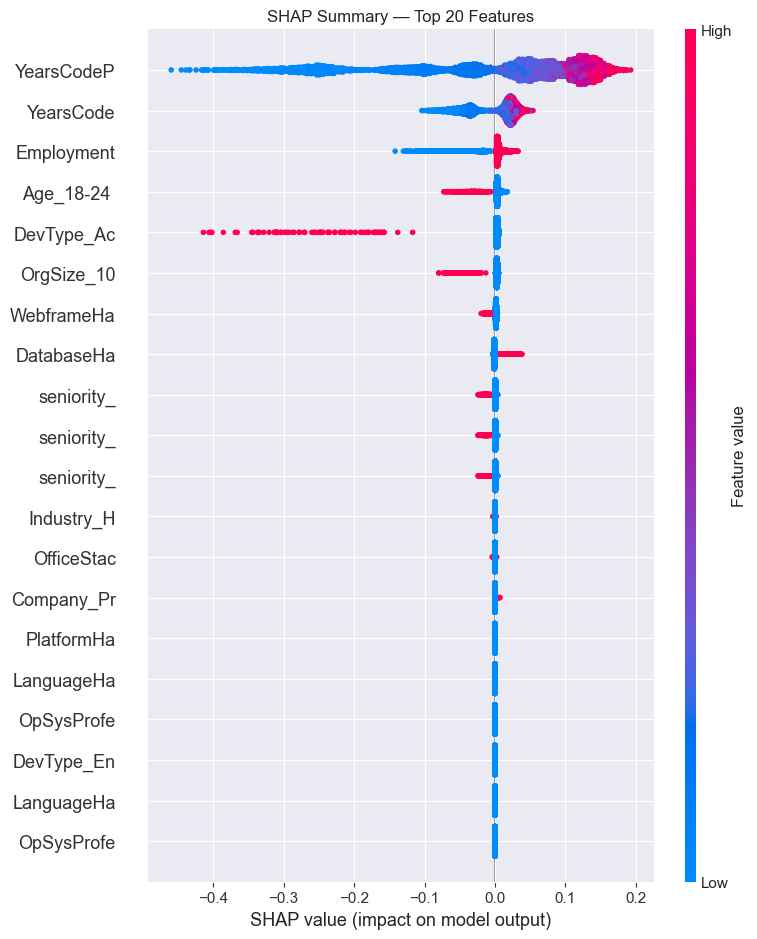

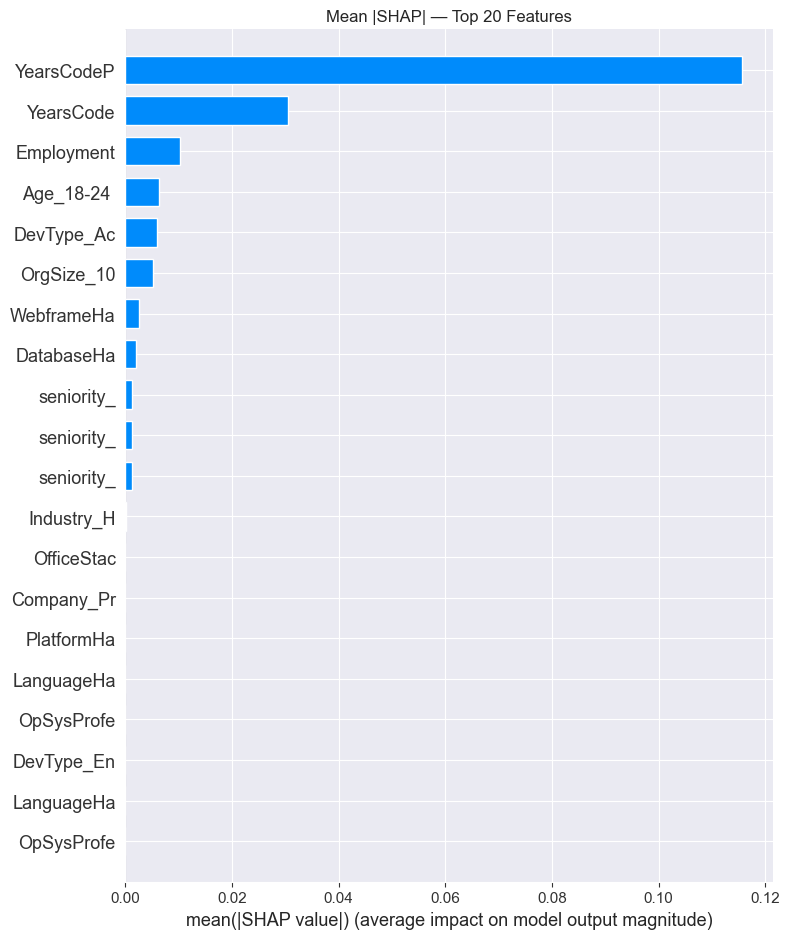

In [45]:
# --- unwrap trained regressor ---
pre = final_pipeline.named_steps["preprocessor"]
model_step = final_pipeline.named_steps["model"]
reg = getattr(model_step, "regressor_", model_step)   # unwrap TTR if present

# --- transformed design matrix (full width) ---
X_trans = pre.transform(X)
try:                      # handle sparse
    import scipy.sparse as sp
    if sp.issparse(X_trans):
        X_trans = X_trans.toarray()
except Exception:
    pass

# --- feature names (post-encoding) ---
num_cols = pre.transformers_[0][2]
cat_cols = pre.transformers_[1][2]
ohe = pre.named_transformers_["cat"]
try:
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
except AttributeError:
    cat_feature_names = ohe.get_feature_names(cat_cols).tolist()
feature_names = list(num_cols) + cat_feature_names
# limit the future_names length
feature_names = [x[:10] for x in feature_names]
# --- top-20 by model importance ---
import numpy as np, pandas as pd, shap, matplotlib.pyplot as plt
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": reg.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)
top20 = fi.head(20)
top20_idx = [feature_names.index(f) for f in top20["feature"]]

# --- SHAP: explain with full feature width, plot top-20 only ---
# Use TreeExplainer (or fallback to generic Explainer)
try:
    explainer = shap.TreeExplainer(reg)
except Exception:
    explainer = shap.Explainer(reg)

sv = explainer(X_trans)   # full-width input that the model was trained on

# normalize to arrays for slicing across SHAP versions
sv_vals = sv.values if hasattr(sv, "values") else sv
X_plot = X_trans

sv_top20 = sv_vals[:, top20_idx]
X_top20  = X_plot[:, top20_idx]
top20_names = top20["feature"].tolist()

plt.figure(figsize=(10, 6))
shap.summary_plot(sv_top20, X_top20, feature_names=top20_names, max_display=20, show=False)
plt.title("SHAP Summary — Top 20 Features"); plt.tight_layout(); plt.show()
plt.figure(figsize=(10, 6))
shap.summary_plot(sv_top20, X_top20, feature_names=top20_names, plot_type="bar", max_display=20, show=False)
plt.title("Mean |SHAP| — Top 20 Features"); plt.tight_layout(); plt.show()
